本コードは2023年8月から9月にかけてSIGNATEで開催されたMUFG Data Science Champion Ship 2023にて用いたコードです。本コンペはクレジットカードの不正決済の予測を行い、159人中7位で金メダルを獲得しました。外部APIを用いた処理はコメントアウトしているため、コンペで提出した予測値とは異なります。

In [1]:
!pip install -U scikit-learn
!pip install shap
!pip install optuna
!pip install catboost
!pip install category_encoders
!pip install lightgbm --upgrade
!pip install pandas-profiling
!pip install geopy

!pip install geopy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━

## データ概要

**学習用データ（train.csv）、評価用データ（test.csv）**

カラム	ヘッダ名称	データ型	説明

0	index	int	インデックス

1	user_id	int	ユーザーのID番号

2	card_id	int	各ユーザーが保有しているカードの識別用ID

3	amount	varchar	カード取引額

4	errors?	varchar	取引が成立したかどうか

**5	is_fraud?	int	不正利用の有無（不正利用あり=1, 不正利用なし=0）**

6	merchant_id	int	利用店舗ID

7	merchant_city	varchar	利用店舗所在市町村

8	merchant_state	char	利用店舗所在州

9	zip	float 利用店舗郵便番号

10	mcc	int	加盟店業種コード

11	use_chip	varchar	カード取引方法

**クレジットカードデータ（card.csv）**

カラム	ヘッダ名称	データ型	説明

0	user_id	int	ユーザーのID番号

1	card_id	int	各ユーザーが保有しているカードの識別用ID

2	card_brand	varchar	カードのブランド

3	card_type	varchar	カードタイプ

4	expires	varchar	有効期限

5	has_chip	varchar Chipがあるかどうか

6	cards_issued	int	アカウントに紐づくカードの発行枚数

7	credit_limit	varchar 利用可能額上限

8	acct_open_date	varchar	アカウント作成日

9	year_pin_last_changed	int	pinコードを最後に変更した日


**ユーザーデータ（user.csv）**

カラム	ヘッダ名称	データ型	説明

0	user_id	int	ユーザーのID番号

1	current_age	int 年齢

2	retirement_age	int 退職年齢

3	birth_year	int	誕生年

4	birth_month	int 誕生月

5	gender	varchar 性別

6	address	varchar	住所詳細

7	city	varchar	市町村

8	state	varchar 州

9	zipcode	int	郵便番号

10	latitude	float 住所の緯度

11	longitude	float 住所の経度

12	per_capita_income_zipcode	varchar 郵便番号区切りの地域ごとの平均年収

13	yearly_income_person	varchar	年収

14	total_debt	varchar	ローン総額

15	fico_score	int	クレジットスコア

16	num_credit_cards	int 所有するクレジットカード枚数

**投稿用サンプルファイル（sample_submit.csv）**

サンプルの予測結果が入力された投稿用ファイルのフォーマット

カラム	ヘッダ名称	データ型	説明

0	無し	int	インデックスとして使用

1	無し	int	不正利用の有無（不正利用あり=1, 不正利用なし=0）

投稿方法

投稿用サンプルファイルのフォーマットに倣い、1列目に評価用データの"id"を、2列目にその"id"に対応する予測した資金調達の成否（0または1）を記入したファイルを作成し、ヘッダ無しのcsv形式で投稿ください。

### トランザクション情報の詳細と考察

1. **amount (取引額)**
   - 最も一般的な取引額: `$1.0`
   - **考察**: トランザクションの平均額が1ドルと非常に低いことがわかります。これは、小額の取引が多いことを示しています。しかし、不正利用は小額の取引で頻繁に行われることがあるため、注意が必要です。異常に高い取引額や多数の小額取引は不正利用の兆候となる可能性があります。

2. **errors? (取引が成立したかどうか)**
   - 一意の値: `OK`, `ERROR`
   - 最も多い値: `OK (405,884回)`
   - **考察**: ほとんどのトランザクションが正常に完了していますが、一部にはエラーが存在します。これらのエラートランザクションは、不正利用の兆候である可能性があります。

3. **is_fraud? (不正利用の有無)**
   - 一意の値: `0 (正常)`, `1 (不正利用)`
   - **考察**: トランザクションの中で不正利用が確認されたものも存在します。これらの不正利用のトランザクションを特定し、分析することで、不正行為を予防するための対策を考えることができます。

4. **merchant_id (加盟店ID)**
   - 一意の加盟店数: 多数
   - **考察**: さまざまな加盟店での取引が行われています。特定の加盟店で不正利用が多発している場合、その加盟店を特定し、対策を講じることができます。

5. **use_chip (取引方法)**
   - 一意の取引方法: `Swipe Transaction`, `Chip Transaction`, `Online Transaction`
   - 最も多い取引方法: `Swipe Transaction (302,862回)`
   - **考察**: スワイプ取引が最も一般的であることがわかります。しかし、チップ取引やオンライン取引も頻繁に行われています。取引方法によって不正利用のリスクが異なる可能性があるため、注意が必要です。チップを使用しない取引は、不正利用のリスクが高い可能性があります。

6. **zip (利用店舗郵便番号)**　データ全体に対する欠損の割合: 約16.81%
   - 平均値: `52,575.38`
   - **考察**: 郵便番号は取引が行われた具体的な地域を示しています。特定の地域での不正利用のリスクを評価するための指標として利用することができます。郵便番号 (zip) が欠損しているデータは利用店舗所在市町村(merchant_city)の多くはアメリカ以外の都市名およびONLINEです。利用店舗所在州または国 (merchant_state)は多数のアメリカ以外の国名があり、海外取引を表しています。

7. **mcc (加盟店業種コード)**
   - 平均値: `5,582.45`
   - **考察**: MCCは取引が行われた業種を示しています。特定の業種での不正利用のリスクが高いかどうかを評価するための指標として利用することができます。
   
8. **merchant_city (利用店舗所在市町村)**
   - 最も一般的な都市: `ONLINE (70,688回)`
   - **考察**: トランザクションの中で、ONLINEが最も一般的な取引先として記録されています。これは、オンラインでの取引が非常に一般的であることを示しています。

9. **merchant_state (利用店舗所在州または国)** データ全体に対する欠損の割合: 約15.00%
   - 最も一般的な州: `TX (40,572回)`
   - **考察**: TX（テキサス州）が最も一般的な取引先の州として記録されています。
   州ごとの取引の頻度を考慮することで、特定の地域での不正利用のリスクを評価することができます。加盟店の所在地(merchant_state) が欠損しているデータは利用店舗所在市町村 (merchant_city):ONLINE のみです。
   
10. **index**

zipでアメリカの郵便番号、zipが欠損だった場合はmerchant cityから都市名を取得して緯度経度を求める、merchant cityがONLINEだった場合は欠損値とする


### カード情報の詳細と考察

1. **card_brand (カードブランド)**
   - 一意のブランド: `Mastercard`, `Visa`, `Discover`, `Amex`
   - 最も多いブランド: `Mastercard (247,843回)`
   - **考察**: MastercardとVisaは、主要なクレジットカードブランドとして広く利用されています。このデータセットでも、これらのブランドが最も一般的であることが確認できます。

2. **card_type (カードタイプ)**
   - 一意のタイプ: `Credit`, `Debit (Prepaid)`, `Debit`
   - 最も多いタイプ: `Debit (278,664回)`
   - **考察**: デビットカードの使用が最も多いことがわかります。デビットカードは、口座の残高を直接引き落とす形式のカードで、クレジットリスクが低いため、多くの人々が利用している可能性があります。

3. **expires (有効期限)**
   - 有効期限の一意の値: `119`
   - 最も一般的な有効期限: `01/2023`
   - **考察**: カードの有効期限は通常数年間となっていますが、このデータセットには多数の有効期限が存在します。これは、カードが異なる時期に発行されたためであると考えられます。

4. **has_chip (チップの有無)**
   - 一意の値: `YES`, `NO`
   - 最も多い値: `YES (431,599回)`
   - **考察**: 近年、カードのセキュリティを向上させるために、多くのカードにチップが組み込まれています。このデータセットでも、チップを持つカードが大多数であることが確認できます。

5. **cards_issued (発行枚数)**
   - 平均値: `1.5枚`
   - 最大値: `3枚`
   - **考察**: 1人のユーザーに対して、平均1.5枚のカードが発行されています。これは、多くのユーザーが複数のカードを持っていることを示しています。
   
6. **year_pin_last_changed (最後にPINコードを変更した年)**
   - 平均値: `2010.94年`
   - 範囲: `2002年 - 2020年`
   - **考察**: この情報は、ユーザーが定期的にPINコードを変更しているかどうかを示しています。定期的なPINコードの変更は、セキュリティを向上させるための良い習慣です。

7. **credit_limit (利用可能額上限)**
   - 最も一般的な利用可能額上限: `$11,300 (4,567回)`
   - **考察**: 利用可能額の上限はユーザーの信用リスクを示す指標の一つです。
   利用可能額の上限が低いユーザーは、高額の取引を行う際に不正利用のリスクが高くなる可能性があります。

8. **acct_open_date (アカウント作成日)**
   - 最も一般的なアカウント作成日: `05/2007 (12,025回)`
   - **考察**: アカウントの作成日は、ユーザーがどれだけ長い間サービスを利用しているかを示しています。新しいアカウントは不正利用のリスクが高い可能性があります。
   
9. card id




   


### ユーザー情報の詳細と考察

1. **current_age (年齢)**
   - 平均年齢: `59.36歳`
   - **考察**: ユーザーの平均年齢は約59歳です。年齢層によって不正利用のリスクが異なる可能性があります。

2. **retirement_age (退職年齢)**
   - 平均退職年齢: `66.45歳`
   - **考察**: ユーザーの平均退職年齢は約66歳です。退職後の生活状況や経済状況によって、不正利用のリスクが変わる可能性があります。

3. **birth_year (誕生年)**
   - 平均値: `1,963.64年`
   - **考察**: ユーザーの平均誕生年は1964年頃です。この情報は、ユーザーの年齢を確認するのに役立ちます。

4. **birth_month (誕生月)**
   - 平均値: `6.52月`
   - **考察**: ユーザーの平均誕生月は6月から7月です。特定の月に生まれたユーザーが不正利用のリスクが高いかどうかを評価するための指標としては使用できません。

5. **address (住所詳細)**
   - 最も一般的な住所: `45235    (1,024回)`
   - **考察**: 住所情報はユーザーの具体的な場所を示しています。特定の住所での不正利用のリスクを評価するための指標として利用することができます。

6. **latitude (住所の緯度)**
   - 平均値: `39.76`
   - **考察**: 緯度情報はユーザーの具体的な地理的な位置を示しています。特定の地域での不正利用のリスクを評価するための指標として利用することができます。

7. **longitude (住所の経度)**
   - 平均値: `-91.38`
   - **考察**: 経度情報はユーザーの具体的な地理的な位置を示しています。特定の地域での不正利用のリスクを評価するための指標として利用することができます。

8. **per_capita_income_zipcode (郵便番号区切りの地域ごとの平均年収)**
   - 最も一般的な平均年収: `$60,000 (4,567回)`
   - **考察**: 平均年収は、ユーザーの経済的な状況を示す指標として利用できます。年収が低いユーザーは、高い金額の取引を行う際に不正利用のリスクが高くなる可能性があります。

9. **total_debt (ローン総額)**
   - 最も一般的なローン総額: `$11,300 (4,567回)`
   - **考察**: ローン総額は、ユーザーの負債の状況を示しています。高いローン総額を持つユーザーは、不正利用のリスクが高まる可能性があります。

10. **num_credit_cards (所有するクレジットカード枚数)**
   - 平均枚数: `3.76枚`
   - **考察**: クレジットカードの所有枚数は、ユーザーのクレジット履歴や信用状況を示す指標の一つとなります。多くのカードを所有しているユーザーは、不正利用のリスクが高まる可能性があります。
11. **gender (性別)**
   - 一意の性別: `Male`, `Female`
   - 最も多い性別: `Female (288,954回)`
   - **考察**: データセットには、女性ユーザーの数が男性よりも多いことが確認できます。

12. **city (市町村)**
   - 一意の都市数: `94`
   - 一部の都市: `Joliet`, `Edgerton`, `Ridgefield`, `Sioux Falls`, `Union City`, ...
   - **考察**: ユーザーはアメリカの様々な都市から来ています。この地理的な情報は、不正利用のリスク分析に役立つ可能性があります。

13. **state (州)**
   - 一意の州数: `37`
   - 一部の州: `IL`, `WI`, `WA`, `SD`, `NJ`, ...
   - **考察**: ユーザーはアメリカの多くの州から来ています。特定の州での不正利用のリスクが高いかどうかを評価するために、この情報を使用することができます。

14. **zipcode (郵便番号)**
   - 平均値: `52,370.95`
   - 範囲: `2,048 - 98,642`
   - **考察**: 郵便番号は、ユーザーの具体的な地理的な位置を示す情報として利用できます。特定の郵便番号エリアでの不正利用のリスクが高いかどうかを判断するための指標として利用することができます。

15. **yearly_income_person (年収)**
   - 平均値: `$76,411.22`
   - **考察**: 年収は、ユーザーの経済的な状況を示す指標として利用できます。年収が低いユーザーは、高い金額の取引を行うときに、不正利用のリスクが高くなる可能性があります。

16. **fico_score (クレジットスコア)**
   - 平均値: `724.96`
   - 範囲: `489 - 850`
   - **考察**: FICOスコアは、ユーザーのクレジットヒストリーと信用リスクを示す指標です。
   高いスコアは、ユーザーが信用リスクが低いことを示しています。このスコアを使用して、不正利用のリスクを評価することができます。
   
   

   
17. **user id**


   ### FICOスコア

- **定義**:
  - FICOスコアは、アメリカの個人の信用スコアを評価するための一般的に使用される指標です。
  - Fair Isaac Corporationが開発したもので、その名前の略です。

- **範囲**:
  - FICOスコアは通常、300から850の範囲でスコアリングされます。
    - **300 - 579**: Poor
    - **580 - 669**: Fair
    - **670 - 739**: Good
    - **740 - 799**: Very Good
    - **800 - 850**: Exceptional

- **計算の要因**:
  - FICOスコアは以下の5つの要因に基づいて計算されます：
    - **支払い履歴 (35%)**: 過去のローンやクレジットカードの支払い履歴。
    - **債務残高 (30%)**: 現在の債務の量。
    - **クレジット履歴の長さ (15%)**: クレジットを持っている期間。
    - **新しいクレジット (10%)**: 最近のクレジットの問い合わせや新しいアカウントの数。
    - **クレジットの種類 (10%)**: 利用しているクレジットの種類（例: クレジットカード、住宅ローン、学生ローンなど）。

- **利用シーン**:
  - ローンやクレジットカードの申し込み時に、金融機関がリスクを評価するために使用されます。
  - 高いFICOスコアは、借り手が信用リスクが低いと見なされることを意味します。

- **注意点**:
  - FICOスコアは、個人の信用履歴のスナップショットであり、時間とともに変動します。
  - 定期的にスコアを確認し、必要に応じてクレジットハビットを調整することが推奨されます。



## 特徴量エンジニアリング

### 1. 取引額関連
- **Z-score**: トランザクションの取引額に関するデータポイントが平均からどれだけ標準偏差単位で離れているかを示す数値、Zスコアを計算します。高いZスコアを持つ取引は、他の取引と比べて異常に取引額が高い（または低い）と判断される可能性があります。
$Z = \frac{X - \mu}{\sigma}$

- **平均取引額**: ユーザーごと、またはカードごとの平均取引額。
- **最大・最小取引額**: ユーザーごと、またはカードごとの最大・最小取引額。
- **取引額の標準偏差**: 各ユーザーの取引額の変動性を表す。
- **移動平均**: ユーザーの取引額の移動平均を計算し、その差分を特徴量として利用。
- **年収と取引額の比**: ユーザーの年収に対する取引額の比率。
  
### 2. 加盟店情報
- **取引回数**: 各加盟店での取引回数を特徴量として考慮します。
- **平均取引額**: 各加盟店での平均取引額を特徴量として考慮します。

### 3. ユーザーの取引履歴
- **直近30日間の取引回数**: ユーザーの直近30日間の取引回数を特徴量として考慮します。
- **直近30日間の平均取引額**: ユーザーの直近30日間の平均取引額を特徴量として考慮します。時間帯別の取引額も検討。
- **直近の取引からの経過時間**: 前回の取引からの経過時間。

### 4. カード情報の利用履歴
- **カード利用率**: トランザクションの合計額をカードの利用可能額上限で割った値を特徴量として考慮します。
- **複数カードでの取引**: 同一ユーザーが複数のカードで取引をしている場合、それを示すフラグを特徴量として考慮します。
- **カード有効期限までの日数**: カードの有効期限までの残り日数を計算。
- **カード発行からの経過日数**: カードの発行日から現在までの日数。
- **複数のカードでの取引**: 1人のユーザーが複数のカードで取引をしている場合のフラグ。

### 5. 地理的な特徴
- **州ごとの平均取引額**: 各州での平均取引額を特徴量として考慮します。
- **州ごとの取引頻度**: 各州での取引の頻度を特徴量として考慮します。
- **取引地域とユーザー住所の一致**: 取引のあった地域とユーザーの住所が一致するかどうかのバイナリ変数。
- **ユーザーの住所と取引地点の距離**: ユーザーの緯度・経度と取引地点の緯度・経度から、距離を計算。

### 6. エンコーディング手法
- **Target Encoding**: カテゴリ変数（例: merchant_city, merchant_state）に対して、不正利用の割合や平均をエンコードして新しい特徴量を生成します。

### 7.アンダーサンプリング
- 多いクラスのデータをランダムに減少させることで、クラス間のバランスを取る方法です。


### geo encodingについて

外部APIを用いているためコメントアウトしています。

In [6]:
import unicodedata
from pathlib import Path
import optuna
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
# import sweetviz as sv

In [4]:
import sklearn
import pickle
sklearn.__version__

'1.3.2'

In [5]:
INPUT_DIR = Path("/content/")

In [7]:
train_data = pd.read_csv(INPUT_DIR / "train.csv")
test_data = pd.read_csv(INPUT_DIR / "test.csv")
user_data = pd.read_csv(INPUT_DIR / "user.csv")
sub_data = pd.read_csv(INPUT_DIR / "sample_submit.csv", names=["id", "price"])
card_data = pd.read_csv(INPUT_DIR / "card.csv")

In [ ]:
# train_data["user_id"].unique()
# Transformed training data shape: (239684, 37)
# Transformed testing data shape: (259106, 37)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import IncrementalPCA

class PreProcessTransformer(TransformerMixin, BaseEstimator):
    # def haversine_distance(self, lat1, lon1, lat2, lon2):
    #     R = 6371.0  # 地球の半径（km）
    #         # 値を浮動小数点型に変換
    #     lat1, lon1, lat2, lon2 = map(float, [lat1, lon1, lat2, lon2])
    #     dlat = np.radians(lat2 - lat1)
    #     dlon = np.radians(lon2 - lon1)
    #     a = (np.sin(dlat / 2) ** 2 +
    #          np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2)
    #     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    #     distance = R * c
    #     return distance

    def fit(self, X, y=None):
        # ユーザーごとのamountの平均と標準偏差を計算
        # print(X.columns)
        if 'amount' in X.columns:
            X_temp = X.copy()
            mask = X_temp['amount'].astype(str).str.contains('\$')
            X_temp.loc[mask, 'amount'] = X_temp.loc[mask, 'amount'].str.replace('$', '', regex=False).astype(float)
            self.user_mean = X_temp.groupby('user_id')['amount'].mean()
            self.user_std = X_temp.groupby('user_id')['amount'].std()

        return self

    def transform(self, X):
        # print(X.columns)
        print(f"Shape of output data: {X.head(5)}")
        if 'merchant_state' in X.columns and 'state' in X.columns:
          X['merchant_state_equals_state'] = (X['merchant_state'] == X['state']).astype(str)

                # amount列の変換
        if 'amount' in X.columns:
            # $記号を削除
            mask = X['amount'].astype(str).str.contains('\$')
            X.loc[mask, 'amount'] = X.loc[mask, 'amount'].str.replace('$', '', regex=False)

            # データ型をfloatに変換
            X['amount'] = X['amount'].astype(float)

        # merchant_idを文字列に変換
        if 'merchant_id' in X.columns:
            X['merchant_id'] = X['merchant_id'].astype(str)


        # Convert other monetary values to float
        monetary_columns = ['credit_limit', 'per_capita_income_zipcode',
                            'yearly_income_person', 'total_debt']

        for col in monetary_columns:
            if col in X.columns:
                mask = X[col].astype(str).str.contains('\$')
                X.loc[mask, col] = X.loc[mask, col].str.replace('$', '', regex=False).astype(float)

        # Convert specific columns to category type
        category_columns = ['merchant_id', 'zip', 'mcc', 'zipcode', 'acct_open_date', 'errors?',
                            'merchant_city', 'merchant_state', 'use_chip', 'card_brand', 'card_type',
                            'expires', 'has_chip', 'gender', 'address', 'city', 'state', 'merchant_state_equals_state']

        for col in category_columns:
            if col in X.columns:
                X[col] = X[col].astype('category')

        if 'acct_open_date' in X.columns:
            X['acct_open_year'] = X['acct_open_date'].str.split('/').str[1].astype(float)
            X['acct_open_month'] = X['acct_open_date'].str.split('/').str[0].astype(float)
            # 2023年を基準に口座開設からの経過年数を計算
            X['years_since_opened'] = 2023 - X['acct_open_year']

        if 'expires' in X.columns:
            X['expires_year'] = X['expires'].str.split('/').str[1].astype(float)
            X['expires_month'] = X['expires'].str.split('/').str[0].astype(float)

        # ユーザーごとのZスコアの計算
        if 'amount' in X.columns:
            X['amount_zscore'] = X.apply(lambda row:
                ((float(row['amount'].replace('$', '')) if isinstance(row['amount'], str) else float(row['amount']))
                - self.user_mean[row['user_id']]) / self.user_std[row['user_id']] if row['user_id'] in self.user_mean.index
                else 0, axis=1)

                    # 同じユーザーの取引についてのamountの平均と標準偏差
        user_amount_diff = X.groupby('user_id')['amount'].diff().fillna(0)
        X['user_amount_diff'] = user_amount_diff

        # 同じユーザーの差分の平均値と標準偏差
        user_diff_mean = X.groupby('user_id')['user_amount_diff'].transform('mean')
        user_diff_std = X.groupby('user_id')['user_amount_diff'].transform('std').fillna(0)

        X['user_diff_mean'] = user_diff_mean
        X['user_diff_std'] = user_diff_std

        X['user_diff_zscore'] = (X['user_amount_diff'] - user_diff_mean) / user_diff_std
        X['user_diff_zscore'].fillna(0, inplace=True)

        # 同じユーザーが連続して同じmerchant_idで取引している回数
        X['user_merchant_consecutive'] = (X.groupby(['user_id', 'merchant_id']).cumcount() + 1)

        # 同じユーザーがそのmerchant_idで取引した回数
        X['user_merchant_count'] = X.groupby(['user_id', 'merchant_id'])['amount'].transform('count')

        # 同じユーザーが連続して同じカードを使っている回数
        X['user_card_consecutive'] = (X.groupby(['user_id', 'card_id']).cumcount() + 1)

        # 同じユーザーが複数のカードで取引した履歴があるかどうかのフラグ
        user_multiple_cards = X.groupby('user_id')['card_id'].nunique() > 1
        X['user_multiple_cards'] = X['user_id'].map(user_multiple_cards).astype(str)

        # yearly_income_personに対する取引額の占める割合
        X['amount_to_income_ratio'] = X['amount'] / X['yearly_income_person']

        # # ハバーサイン公式を使用して距離を計算
        # X['distance'] = X.apply(
        #     lambda row: self.haversine_distance(row['latitude'], row['longitude'],
        #                                         row['transaction_latitude'], row['transaction_longitude'])
        #     if pd.notnull(row['transaction_latitude']) and pd.notnull(row['transaction_longitude']) else np.nan,
        #     axis=1)

        # # ユーザーごとの距離の平均と標準偏差を計算
        # X["distance_mean"] = X.groupby('user_id')['distance'].transform('mean')
        # X["distance_std"] = X.groupby('user_id')['distance'].transform('std').fillna(0)

        # # Zスコアを計算
        # X['distance_zscore'] = (X['distance'] - X["distance_mean"]) / X["distance_std"]
        # X['distance_zscore'].fillna(0, inplace=True)

        print(f"Shape of output data: {X.shape}")
        return X

class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

class OnlinePCAEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, cat_columns, n_components=2, batch_size=1000):
        self.cat_columns = cat_columns
        self.n_components = n_components
        self.batch_size = batch_size
        self.encoders = {}
        self.pcas = {}

    def fit(self, X, y=None):
        for col in self.cat_columns:
            print(f"Processing column: {col} for fitting...")  # 進行状況を表示
                        # Convert all values to string
            X[col] = X[col].astype(str)

            # Ensure the column is of categorical type
            if not pd.api.types.is_categorical_dtype(X[col]):
                X[col] = X[col].astype('category')

            # Add 'MISSING_VALUE' to the categories if it's not present
            if "MISSING_VALUE" not in X[col].cat.categories:
                X[col] = X[col].cat.add_categories(['MISSING_VALUE'])

            # Fill NA with 'MISSING_VALUE'
            X[col].fillna("MISSING_VALUE", inplace=True)

            ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
            encoded_data = ohe.fit_transform(X[[col]])
            self.encoders[col] = ohe

            pca = IncrementalPCA(n_components=self.n_components)
            n_batches = int(np.ceil(encoded_data.shape[0] / self.batch_size))
            for batch_idx in range(n_batches):
                start = batch_idx * self.batch_size
                end = (batch_idx + 1) * self.batch_size
                print(f"Fitting PCA for batch {batch_idx+1} of {n_batches}...")  # バッチごとの進行状況を表示
                pca.partial_fit(encoded_data[start:end])

            self.pcas[col] = pca

        return self

    def transform(self, X):
        all_pca_features = []
        for col, encoder in self.encoders.items():
            print(f"Processing column: {col} for transformation...")  # 進行状況を表示
            if col not in X.columns:
                continue

            # Ensure the column is of categorical type
            if not pd.api.types.is_categorical_dtype(X[col]):
                X[col] = X[col].astype('category')

            if "MISSING_VALUE" not in X[col].cat.categories:
                X[col] = X[col].astype('category').cat.add_categories(['MISSING_VALUE'])
            X[col].fillna("MISSING_VALUE", inplace=True)
            encoded_data = encoder.transform(X[[col]])

            pca_features = self.pcas[col].transform(encoded_data)
            pca_df = pd.DataFrame(pca_features, columns=[f"{col}_pca_{i}" for i in range(self.n_components)])
            all_pca_features.append(pca_df)

        return pd.concat(all_pca_features, axis=1)

from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded
from geopy.extra.rate_limiter import RateLimiter

import requests
from sklearn.base import TransformerMixin, BaseEstimator
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded
from geopy.extra.rate_limiter import RateLimiter

import pickle
import os

class GeoCodingTransformer(TransformerMixin, BaseEstimator):
    CACHE_FILE = "/content/geo_cache.pkl"  # キャッシュデータの保存先

    LOCATIONIQ_LIMIT = 5000
    OPENCAGE_LIMIT = 2500

    def __init__(self, locationiq_api_key, opencage_api_key, max_retries=3):
        # 初期化
        self.locationiq_api_key = locationiq_api_key
        self.opencage_api_key = opencage_api_key
        self.max_retries = max_retries
        self.geocode = RateLimiter(self._geocode_func, min_delay_seconds=1)
        self.limit_reached = False

        # キャッシュの読み込み
        if os.path.exists(self.CACHE_FILE):
            with open(self.CACHE_FILE, "rb") as f:
                self.cache = pickle.load(f)
        else:
            self.cache = {}
            self.locationiq_counter = 0
            self.opencage_counter = 0

    # def _geocode_func(self, query):
    #     # LocationIQかOpencageのどちらを使用するかを判断する関数
    #     if not self.limit_reached:
    #         try:
    #             return self.geocode_locationiq(query)
    #         except:
    #             self.limit_reached = True
    #             return self.geocode_opencage(query)
    #     else:
    #         return self.geocode_opencage(query)

    def _geocode_func(self, query):
        if not self.limit_reached and self.locationiq_counter < self.LOCATIONIQ_LIMIT:
            try:
                result = self.geocode_locationiq(query)
                self.locationiq_counter += 1  # カウンタをインクリメント
                print(result)
                print(f"locationiq_counter : {self.locationiq_counter}")
                return result
            except:
                self.limit_reached = True
                return self.geocode_opencage(query)
        elif self.opencage_counter < self.OPENCAGE_LIMIT:
            result = self.geocode_opencage(query)
            print(result)
            self.opencage_counter += 1  # カウンタをインクリメント
            print(f"opencage_counter : {self.opencage_counter}")
            return result
        else:
            raise Exception("Both API limits have been reached!")

    def geocode_locationiq(self, address):
        base_url = "https://us1.locationiq.com/v1/search.php"
        params = {
            'key': self.locationiq_api_key,
            'q': address,
            'format': 'json'
        }
        response = requests.get(base_url, params=params)
        data = response.json()[0]
        return data['lat'], data['lon']

    def geocode_opencage(self, address):
        base_url = "https://api.opencagedata.com/geocode/v1/json"
        params = {
            'key': self.opencage_api_key,
            'q': address,
            'no_annotations': 1
        }
        response = requests.get(base_url, params=params)
        data = response.json()
        if len(data['results']) == 0:
            return None, None
        result = data['results'][0]
        return result['geometry']['lat'], result['geometry']['lng']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['transaction_latitude'] = None
        X['transaction_longitude'] = None
        print(f"Shape of input data: {X.head(5)}")
        # フルアドレスの作成
        X['full_address'] = X['merchant_city'] + ', ' + X['merchant_state']
        unique_addresses = X['full_address'].unique()
        total_addresses = len(unique_addresses)

        for idx, address in enumerate(unique_addresses):

            # "ONLINE"の場合またはaddressがNaNの場合は続行
            if pd.isna(address) or "ONLINE" in address:
                X.loc[X['full_address'] == address, ['transaction_latitude', 'transaction_longitude']] = np.nan
                continue

            if address in self.cache:
                lat, lon = self.cache[address]
            else:
                lat, lon = self._geocode_func(address)
                self.cache[address] = (lat, lon)

            print(f"Processed Address {idx+1} out of {total_addresses} unique addresses.")

            X.loc[X['full_address'] == address, 'transaction_latitude'] = lat
            X.loc[X['full_address'] == address, 'transaction_longitude'] = lon

        X = X.drop(columns=['full_address'])
        print(f"Shape of output data: {X.shape}")
        # キャッシュの保存
        # with open(self.CACHE_FILE, "wb") as f:
        #     pickle.dump(self.cache, f)

        return X

# ColumnTransformerの定義
preprocessing = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['amount', 'credit_limit', 'per_capita_income_zipcode',
                                'yearly_income_person', 'total_debt', 'cards_issued',
                                'year_pin_last_changed', 'current_age', 'retirement_age',
                                'birth_year', 'birth_month',  'latitude', 'longitude', 'fico_score', 'num_credit_cards',
                                'acct_open_year', 'amount_zscore', 'acct_open_month',
#                                 'years_since_opened'
#                                  'expires_year',
#                                 'expires_month',
#                                'index', 'user_id', 'card_id',
                            'user_amount_diff',
                            'user_diff_mean',
                            'user_diff_zscore',
                            'user_merchant_consecutive',
                            'user_merchant_count',
                            'amount_to_income_ratio',
                            # 'transaction_latitude',
                            # 'transaction_longitude',
                            # 'distance',
                            # 'distance_zscore',
                            # "distance_std",
                            # "distance_mean"

                               ]),
        ('cat', 'passthrough', ['errors?', 'merchant_city', 'merchant_state',
                                'use_chip', 'card_brand', 'card_type', 'has_chip','zipcode',
                                'gender', 'city', 'state','merchant_id', 'zip', 'mcc',
                               'acct_open_date',
                                'address',
                                'expires',

                            'merchant_state_equals_state',
                            'user_multiple_cards'
                               ]),
                *[
            (f"agg_{key}", AggTransformer(key, ["amount"], {"median"}), [key] + ["amount"])
            for key in [
                # 'errors?',
                # 'merchant_city',
                'merchant_state',
                # 'use_chip',
                # 'card_brand',
                # 'card_type',
                # 'has_chip',
                # 'zipcode',
                # 'gender',
                # 'city',
                'state',
                # 'merchant_id',
                'zip',
                'mcc',
                              #  'acct_open_date',
                                # 'address',
                                # 'expires',
            ]
        ]
    ]
)
# locationiq_api_key = "pk.119fb1c4777398d216cb60610b3d7902"
# opencage_api_key = "2075899cb2f245ce897064b2bc1e3433"

# geo_transformer = GeoCodingTransformer(locationiq_api_key, opencage_api_key)
preprocessing.set_output(transform="pandas")
# パイプラインの定義
pipeline = Pipeline([
    # ('geocoding', GeoCodingTransformer(locationiq_api_key="pk.119fb1c4777398d216cb60610b3d7902",
    #                                    opencage_api_key="2075899cb2f245ce897064b2bc1e3433")),
    ('preprocess', PreProcessTransformer()),
    ('preprocessing', preprocessing)
])
# Merge train data with card and user data
combined_train_df = pd.merge(train_data, card_data, on=['user_id', 'card_id'], how='left')
combined_train_data = pd.merge(combined_train_df, user_data, on='user_id', how='left')

# Merge train data with card and user data
combined_test_df = pd.merge(test_data, card_data, on=['user_id', 'card_id'], how='left')
combined_test_data = pd.merge(combined_test_df, user_data, on='user_id', how='left')

# Separate target variable
y_train = combined_train_data['is_fraud?']

# Drop the target variable from the datasets
combined_train_data = combined_train_data.drop(columns=['is_fraud?'])

# combined_train_data_transformed_befo_pca = combined_train_data[(combined_train_data["merchant_city"] == "ONLINE") | (combined_train_data["merchant_city"] == "Tokyo")].head(10).reset_index(drop=True)
# combined_test_data_transformed_befo_pca = combined_test_data[(combined_test_data["merchant_city"] == "ONLINE") | (combined_test_data["merchant_city"] == "Tokyo")].head(10).reset_index(drop=True)


# # パイプラインの適用
combined_train_data_transformed_befo_pca = pipeline.fit_transform(combined_train_data)
combined_test_data_transformed_befo_pca = pipeline.transform(combined_test_data)


# # 前処理されたデータを結合
combined_data_preprocessed = pd.concat([combined_train_data_transformed_befo_pca, combined_test_data_transformed_befo_pca], axis=0)

# # PCA特徴量の追加
online_pca = OnlinePCAEncoder(cat_columns=[
    # 'cat__merchant_city',
    # 'cat__merchant_id',
    'cat__merchant_state',
    'cat__acct_open_date',
    'cat__address',
    'cat__zipcode',
    'cat__city',
    'cat__mcc',
    'cat__expires',
    # 'cat__zip',

    # 'cat__state',
    ], n_components=4)

online_pca.fit(combined_data_preprocessed)
pca_features = online_pca.transform(combined_data_preprocessed)
pca_features.index = combined_data_preprocessed.index  # インデックスの修正

# # 前処理されたデータとPCA特徴量を結合
combined_data_transformed = pd.concat([combined_data_preprocessed, pca_features], axis=1)

# # 訓練データとテストデータの再分割
train_len = len(combined_train_data_transformed_befo_pca)
combined_train_data_transformed = combined_data_transformed[:train_len]
combined_test_data_transformed = combined_data_transformed[train_len:]

# combined_train_data_transformed["num__transaction_longitude"] = combined_train_data_transformed["num__transaction_longitude"].astype(float)
# combined_train_data_transformed["num__transaction_latitude"] = combined_train_data_transformed["num__transaction_latitude"].astype(float)

# combined_test_data_transformed["num__transaction_longitude"] = combined_test_data_transformed["num__transaction_longitude"].astype(float)
# combined_test_data_transformed["num__transaction_latitude"] = combined_test_data_transformed["num__transaction_latitude"].astype(float)


print("Train Data Shape:", train_data.shape)
print("Card Data Shape:", card_data.shape)
print("User Data Shape:", user_data.shape)
print("Combined Train Data Shape:", combined_train_data.shape)
print("Transformed training data before PCA shape:", combined_train_data_transformed_befo_pca.shape)
print("Transformed testing data before PCA shape:", combined_test_data_transformed_befo_pca.shape)
print("Transformed training data shape:", combined_train_data_transformed.shape)
print("Transformed testing data shape:", combined_test_data_transformed.shape)



<ipython-input-10-d07f5bd290b1>:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_temp.loc[mask, 'amount'] = X_temp.loc[mask, 'amount'].str.replace('$', '', regex=False).astype(float)


Shape of output data:    index  user_id  card_id   amount errors?  merchant_id merchant_city  \
0      0     1721        0   $2.623      OK       209237        Joliet   
1      1     1629        3     $6.4      OK         2568      Edgerton   
2      2      655        3   $123.5      OK       345310    Ridgefield   
3      3      492        0  $51.287      OK         4295        Milton   
4      4     1969        4  $17.561      OK       350447     Irvington   

  merchant_state      zip     mcc  ...         city state zipcode latitude  \
0             IL  60436.0  5541.0  ...       Joliet    IL   60436    41.52   
1             WI  53534.0  5814.0  ...     Edgerton    WI   53534    42.83   
2             WA  98642.0  7538.0  ...   Ridgefield    WA   98642    45.79   
3             FL  32583.0  5912.0  ...  Sioux Falls    SD   57107    43.54   
4             NJ   7111.0  4214.0  ...   Union City    NJ    7087    40.76   

  longitude  per_capita_income_zipcode yearly_income_person tota

<ipython-input-10-d07f5bd290b1>:60: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[mask, col] = X.loc[mask, col].str.replace('$', '', regex=False).astype(float)


Shape of output data: (281899, 51)
Shape of output data:     index  user_id  card_id    amount errors?  merchant_id      merchant_city  \
0  471283      541        3  $113.278      OK     324189.0            Orlando   
1  471284      655        1  $293.944      OK      81219.0         Ridgefield   
2  471285      492        0     $47.4      OK     274755.0  Arlington Heights   
3  471286      236        1    $167.0      OK     255962.0           Berkeley   
4  471287      882        2  $126.619   ERROR     271748.0          Rochester   

  merchant_state      zip     mcc  ...         city state zipcode latitude  \
0             FL  32821.0  4814.0  ...      Orlando    FL   32818    28.50   
1             WA  98642.0  7538.0  ...   Ridgefield    WA   98642    45.79   
2             IL  60004.0  5719.0  ...  Sioux Falls    SD   57107    43.54   
3             CA  94702.0  5300.0  ...      Hickman    NE   68372    40.62   
4             MN  55901.0  4829.0  ...    Rochester    MN   55901 

<ipython-input-10-d07f5bd290b1>:60: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[mask, col] = X.loc[mask, col].str.replace('$', '', regex=False).astype(float)


Shape of output data: (288029, 51)
Processing column: cat__merchant_state for fitting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting PCA for batch 1 of 570...
Fitting PCA for batch 2 of 570...
Fitting PCA for batch 3 of 570...
Fitting PCA for batch 4 of 570...
Fitting PCA for batch 5 of 570...
Fitting PCA for batch 6 of 570...
Fitting PCA for batch 7 of 570...
Fitting PCA for batch 8 of 570...
Fitting PCA for batch 9 of 570...
Fitting PCA for batch 10 of 570...
Fitting PCA for batch 11 of 570...
Fitting PCA for batch 12 of 570...
Fitting PCA for batch 13 of 570...
Fitting PCA for batch 14 of 570...
Fitting PCA for batch 15 of 570...
Fitting PCA for batch 16 of 570...
Fitting PCA for batch 17 of 570...
Fitting PCA for batch 18 of 570...
Fitting PCA for batch 19 of 570...
Fitting PCA for batch 20 of 570...
Fitting PCA for batch 21 of 570...
Fitting PCA for batch 22 of 570...
Fitting PCA for batch 23 of 570...
Fitting PCA for batch 24 of 570...
Fitting PCA for batch 25 of 570...
Fitting PCA for batch 26 of 570...
Fitting PCA for batch 27 of 570...
Fitting PCA for batch 28 of 570...
Fitting PCA for batch 29 of 5

In [11]:
# combined_train_data_transformed["num__transaction_longitude"] = combined_train_data_transformed["num__transaction_longitude"].astype(float)
# combined_train_data_transformed["num__transaction_latitude"] = combined_train_data_transformed["num__transaction_latitude"].astype(float)

# combined_test_data_transformed["num__transaction_longitude"] = combined_test_data_transformed["num__transaction_longitude"].astype(float)
# combined_test_data_transformed["num__transaction_latitude"] = combined_test_data_transformed["num__transaction_latitude"].astype(float)

In [12]:
combined_train_data_transformed.info()
# combined_data_transformed["num__transaction_longitude"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281899 entries, 0 to 281898
Data columns (total 75 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   num__amount                        281899 non-null  float64 
 1   num__credit_limit                  281899 non-null  float64 
 2   num__per_capita_income_zipcode     281899 non-null  float64 
 3   num__yearly_income_person          281899 non-null  float64 
 4   num__total_debt                    281899 non-null  float64 
 5   num__cards_issued                  281899 non-null  int64   
 6   num__year_pin_last_changed         281899 non-null  int64   
 7   num__current_age                   281899 non-null  int64   
 8   num__retirement_age                281899 non-null  int64   
 9   num__birth_year                    281899 non-null  int64   
 10  num__birth_month                   281899 non-null  int64   
 11  num__latitude             

In [13]:
# len(train_data["merchant_city"].unique()) #4396
# len(train_data["merchant_state"].unique()) #117

In [14]:
# combined_train_data_transformed.info()
# combined_train_data_transformed_befo_pca.info()

In [15]:
# with open("/content/geo_cache.pkl", "rb") as file:
#     cache_contents = pickle.load(file)

# # キャッシュの内容の一部を確認
# sample_entries = dict(list(cache_contents.items())[:5])
# number_of_entries = len(cache_contents)

# sample_entries, number_of_entries
# data = cache_contents
# if isinstance(data, dict):
#     unique_keys = len(data.keys())
#     print(f"Number of unique keys: {unique_keys}")
# else:
#     print("The data structure is not a dictionary.")
# print(cache_contents)
# train_data

In [16]:
# train_data['full_address'] = train_data['merchant_city'] + ', ' + train_data['merchant_state']
# unique_addresses = train_data['full_address'].unique()
# len(unique_addresses)
# len(train_data['merchant_city'].unique())

In [17]:
# grouped = train_data.groupby('merchant_city')['full_address'].nunique()
# cities_with_multiple_addresses = grouped[grouped > 1].index

# for city in cities_with_multiple_addresses:
#     addresses_for_city = train_data[train_data['merchant_city'] == city]['full_address'].unique()
#     print(f"City: {city}")
#     for address in addresses_for_city:
#         print(f"  - {address}")
#     print("\n")


In [18]:
# import requests

# def opencage_geocode(address, api_key):
#     base_url = "https://api.opencagedata.com/geocode/v1/json"
#     params = {
#         'key': api_key,
#         'q': address,
#         'no_annotations': 1
#     }
#     response = requests.get(base_url, params=params)

#     if response.status_code != 200:
#         print(f"Request failed with status code {response.status_code}")
#         return None, None

#     data = response.json()
#     if len(data['results']) == 0:
#         print("No results found")
#         return None, None

#     result = data['results'][0]
#     return result['geometry']['lat'], result['geometry']['lng']
# address = 'Joliet, IL'
# open_cage_api_key = "2075899cb2f245ce897064b2bc1e3433"
# latitude, longitude = opencage_geocode(address, open_cage_api_key)

# if latitude and longitude:
#     print(f"Latitude: {latitude}, Longitude: {longitude}")
# else:
#     print("Failed to retrieve geocoding information.")

In [19]:
# api_key = "pk.119fb1c4777398d216cb60610b3d7902"
# address = "Joliet, IL"
# import requests

# def geocode(address, api_key):
#     base_url = "https://us1.locationiq.com/v1/search.php"
#     params = {
#         'key': api_key,
#         'q': address,
#         'format': 'json'
#     }
#     response = requests.get(base_url, params=params)
#     data = response.json()[0]
#     return data['lat'], data['lon']
# geocode(address, api_key)

##zip (利用店舗郵便番号)　データ全体に対する欠損の割合: 約16.81%##

平均値: 52,575.38

考察: 郵便番号は取引が行われた具体的な地域を示しています。特定の地域での不正利用のリスクを評価するための指標として利用することができます。郵便番号 (zip) が欠損しているデータは利用店舗所在市町村(merchant_city)の多くはアメリカ以外の都市名およびONLINEです。利用店舗所在州または国 (merchant_state)は多数のアメリカ以外の国名があり、海外取引を表しています。

##merchant_city (利用店舗所在市町村)##

最も一般的な都市: ONLINE (70,688回)

考察: トランザクションの中で、ONLINEが最も一般的な取引先として記録されています。これは、オンラインでの取引が非常に一般的であることを示しています。

##merchant_state (利用店舗所在州または国) データ全体に対する欠損の割合: 約15.00%##

最も一般的な州: TX (40,572回)

考察: TX（テキサス州）が最も一般的な取引先の州として記録されています。 州ごとの取引の頻度を考慮することで、特定の地域での不正利用のリスクを評価することができます。加盟店の所在地(merchant_state) が欠損しているデータは利用店舗所在市町村 (merchant_city):ONLINE のみです。

In [ ]:
# train_data[(train_data['merchant_state'].str.len() != 2) & (train_data['merchant_city'] != "ONLINE")]

In [ ]:
# train_data.head()

In [ ]:
# combined_train_data_transformed.info()

In [20]:
# # train_data.isnull().sum()
# # combined_test_data_transformed["num__amount"]
# def list_unique_values(df):
#     """
#     データフレーム内のカテゴリ変数の各カラムに含まれるユニークな値の数を列挙する。

#     Parameters:
#     - df: データフレーム

#     Returns:
#     - ユニークな値の数を含む辞書
#     """
#     categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
#     unique_counts = {}

#     for col in categorical_cols:
#         unique_counts[col] = df[col].nunique()

#     return unique_counts
# list_unique_values(combined_train_data_transformed)

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import numpy as np
import shap

def get_cv(df, n_fold=5, random_state=71):
    """KFold交差検証のインデックスを取得する関数

    Parameters:
    - df: DataFrame, 入力データ
    - n_fold: int, 分割数

    Returns:
    - list: 訓練データと検証データのインデックスのリスト
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state = random_state)
    return list(kf.split(df))

def under_sampling(df, sampling_multiplier=1.0, random_state_us=71):
    """アンダーサンプリングを行う関数

    Parameters:
    - df: DataFrame, 入力データ
    - sampling_multiplier: float, 少数クラスのデータ数を基準とした多数クラスのサンプリング倍率

    Returns:
    - DataFrame: サンプリング後のデータ
    """
    # 0と1のデータを分割
    fraud_df = df[df['is_fraud?'] == 1]
    non_fraud_df = df[df['is_fraud?'] == 0]

    # 少数クラスのデータ数を基準にして多数クラスのサンプリング数を計算
    n_samples = int(len(fraud_df) * sampling_multiplier)

    # 多数クラスから指定された数だけサンプルをランダムに取得
    non_fraud_df_sampled = non_fraud_df.sample(n=n_samples, random_state=random_state_us)

    # サンプリングされたデータを結合して返す
    return pd.concat([fraud_df, non_fraud_df_sampled], axis=0)

def fit_lgbm(X, y, cv, categorical_cols=None, params=None, sampling_rate=1.0, verbose=False, random_state_us=71):
    """LightGBMのモデルを訓練する関数

    Parameters:
    - X: DataFrame, 入力特徴量
    - y: Series or ndarray, 目的変数
    - cv: list, 交差検証のインデックスのリスト
    - categorical_cols: list, カテゴリ変数のリスト
    - params: dict, LightGBMのパラメータ
    - sampling_rate:
    - verbose: int, ログの表示頻度

    Returns:
    - tuple: 最終的なF1スコア、OOFの予測値、訓練されたモデルのリスト
    """
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
        }

    models = []
    oof_pred = np.zeros(len(X), dtype=np.float32)
    # SHAP値を保存するためのリスト
    shap_values_list = []

    for i, (idx_train, idx_valid) in enumerate(cv):
        # トレーニングフォールドに対してアンダーサンプリング
        sampled_df = under_sampling(pd.concat([X.iloc[idx_train], y.iloc[idx_train]], axis=1), sampling_rate, random_state_us)
        x_train_sampled = sampled_df.drop(columns=['is_fraud?'])
        y_train_sampled = sampled_df['is_fraud?']

        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMClassifier(**params)
        model.fit(x_train_sampled, y_train_sampled, eval_set=[(x_valid, y_valid)])

        # SHAP Explainerの初期化とSHAP値の計算
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X.iloc[idx_valid])
        shap_values_list.append(shap_values)

        # 予測値を0 or 1に変換
        pred_i = (model.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
        oof_pred[idx_valid] = pred_i

        models.append(model)

        score = f1_score(y_valid, pred_i)
        print(f"Fold {i + 1} F1 Score: {score:.4f}")

    score = f1_score(y, oof_pred)
    print(f"Overall F1 Score: {score:.4f}")

    # 最終的なF1スコア、OOFの予測値、訓練されたモデルのリスト、各モデルのSHAP値を返す
    return score, oof_pred, models, shap_values_list

import catboost as cb
from sklearn.metrics import f1_score

def fit_catboost(X, y, cv, categorical_cols=None, params=None, sampling_rate=1.0, verbose=False, random_state_us=71):
    """CatBoostのモデルを訓練する関数"""
     # カテゴリ変数の各値を文字列に変換
    for col in categorical_cols:
        X[col] = X[col].astype(str)

    # カテゴリ変数を category dtype に変換
    for col in categorical_cols:
        X[col] = X[col].astype('category')

    # カテゴリ変数に "missing" カテゴリを追加
    for col in categorical_cols:
        if not "missing" in X[col].cat.categories:
            X[col] = X[col].cat.add_categories("missing")

    if params is None:
        params = {
            'objective': 'Logloss',
            'verbose': verbose,
            'random_state': random_state_us
        }

    models = []
    oof_pred = np.zeros(len(X), dtype=np.float32)
    shap_values_list = []

    best_thresholds = []

    for i, (idx_train, idx_valid) in enumerate(cv):
        # トレーニングフォールドに対してアンダーサンプリング
        sampled_df = under_sampling(pd.concat([X.iloc[idx_train], y.iloc[idx_train]], axis=1), sampling_rate, random_state_us)
        x_train_sampled = sampled_df.drop(columns=['is_fraud?'])
        y_train_sampled = sampled_df['is_fraud?']

        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_data = cb.Pool(data=x_train_sampled, label=y_train_sampled, cat_features=categorical_cols)
        valid_data = cb.Pool(data=x_valid, label=y_valid, cat_features=categorical_cols)

        model = cb.CatBoostClassifier(**params)
        model.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100,verbose=verbose)

        # 予測確率を取得
        probas = model.predict_proba(x_valid)[:, 1]

        # 最適な閾値を探す
        best_score = -1
        best_threshold = 0.5
        for threshold in np.linspace(0.01, 0.99, 100):
            preds = (probas > threshold).astype(int)
            score = f1_score(y_valid, preds)
            if score > best_score:
                best_score = score
                best_threshold = threshold
        best_thresholds.append(best_threshold)

        # 予測値を最適な閾値で0 or 1に変換
        pred_i = (probas > best_threshold).astype(int)
        oof_pred[idx_valid] = pred_i

        # SHAP値の計算
        explainer = model.get_feature_importance(valid_data, type="ShapValues")
        shap_values = explainer[:,:-1]
        shap_values_list.append(shap_values)

        models.append(model)

        print(f"Fold {i + 1} Best Threshold: {best_threshold:.4f}")
        print(f"Fold {i + 1} F1 Score: {best_score:.4f}")

    overall_threshold = np.mean(best_thresholds)
    print(f"Overall Best Threshold: {overall_threshold:.4f}")

    score = f1_score(y, oof_pred)
    print(f"Overall F1 Score: {score:.4f}")

    # 最終的なF1スコア、OOFの予測値、訓練されたモデルのリスト、各モデルのSHAP値、全体の最適な閾値を返す
    return score, oof_pred, models, shap_values_list, overall_threshold


In [ ]:
# import matplotlib.pyplot as plt

# def find_best_sampling_rate(X, y, cv, categorical_cols=None, params=None, sampling_rates=None):
#     """最適なサンプリング倍率を探す関数

#     Parameters:
#     - X: DataFrame, 入力特徴量
#     - y: Series or ndarray, 目的変数
#     - cv: list, 交差検証のインデックスのリスト
#     - categorical_cols: list, カテゴリ変数のリスト
#     - params: dict, LightGBMのパラメータ
#     - sampling_rates: list, 試すサンプリング倍率のリスト

#     Returns:
#     - tuple: 最適なサンプリング倍率、そのときのF1スコア、全てのサンプリング倍率のリスト、対応するF1スコアのリスト
#     """

#     # 試すサンプリング倍率が指定されていない場合は、デフォルトのリストを使用
#     if sampling_rates is None:
#         sampling_rates = [1.0, 1.25, 1.5, 1.75, 2.0]

#     best_score = 0
#     best_rate = None
#     scores = []

#     # 各サンプリング倍率でモデルを訓練し、F1スコアを計算
#     for rate in sampling_rates:
#         score_folds = []
#         for i, (idx_train, idx_valid) in enumerate(cv):
#             X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#             X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#             # トレーニングフォールドに対してアンダーサンプリング
#             sampled_df = under_sampling(pd.concat([X_train, y_train], axis=1), rate)
#             X_sampled = sampled_df.drop(columns=['is_fraud?'])
#             y_sampled = sampled_df['is_fraud?']

#             # 1つのフォールドでモデルを訓練
#             model = lgb.LGBMClassifier(**params)
#             model.fit(X_sampled, y_sampled, categorical_feature=categorical_cols)
#             preds = model.predict(X_valid)
#             score_folds.append(f1_score(y_valid, preds))
#             score = f1_score(y_valid, preds)
#             print(f"fold {i + 1} - F1 Score: {score:.4f}")

#         # 各フォールドの平均スコアを使用
#         score = np.mean(score_folds)
#         scores.append(score)

#         # 最も良いスコアを更新
#         if score > best_score:
#             best_score = score
#             best_rate = rate

#         print(f"Sampling Rate {rate} F1 Score: {score:.4f}")

#     # サンプリング倍率と精度のグラフを表示
#     plt.figure(figsize=(10, 6))
#     plt.plot(sampling_rates, scores, marker="o", linestyle='-')
#     plt.xlabel("Sampling Rate")
#     plt.ylabel("F1 Score")
#     plt.title("Sampling Rate vs F1 Score")
#     plt.grid(True)
#     plt.show()

#     print(f"Best Sampling Rate: {best_rate} with F1 Score: {best_score:.4f}")
#     return best_rate, best_score, sampling_rates, scores


In [22]:
# CatBoostのハイパーパラメータ
cat_params = {
    'iterations': 300,
    'learning_rate': 0.22,
    'depth': 6,
    'random_seed': 71,
}

categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

cv = get_cv(combined_train_data_transformed, n_fold=10, random_state=71)

score_cat, oof_cat, models_cat, shap_values_list_cat, overall_threshold = fit_catboost(
    combined_train_data_transformed,
    y_train,
    cv,
    categorical_cols=categorical_cols,
    params=cat_params,
    sampling_rate=6.8,
    random_state_us=71,
    verbose=False  # この行を追加
)

def catboost_categorical_transform(X):
    # カテゴリ変数の各値を文字列に変換
    for col in categorical_cols:
        X[col] = X[col].astype(str)

    # カテゴリ変数を category dtype に変換
    for col in categorical_cols:
        X[col] = X[col].astype('category')

    # カテゴリ変数に "missing" カテゴリを追加
    for col in categorical_cols:
        if not "missing" in X[col].cat.categories:
            X[col] = X[col].cat.add_categories("missing")

    return X
# テストデータに対する予測を行う（catboostモデル単体）

def predict_with_catboost(models, X):

  pred_proba = np.zeros(len(X))

  for model in models:
    pred_proba += model.predict_proba(X)[:, 1]

  pred_proba /= len(models)

  return pred_proba

combined_test_data_transformed = catboost_categorical_transform(combined_test_data_transformed)

train_preds_p_cat = predict_with_catboost(models_cat, combined_train_data_transformed)
test_preds_p_cat = predict_with_catboost(models_cat, combined_test_data_transformed)


combined_train_data_transformed["stack_model_pred_cat"] = train_preds_p_cat
combined_test_data_transformed["stack_model_pred_cat"] = test_preds_p_cat


# 1. モデルの訓練
# ハイパーパラメータは適切なものを設定する必要があります。今回はデフォルトを使用します。
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'random_state': 71,
    'boosting_type': 'gbdt',
    # 'n_estimators' : 300
#     'boosting_type': 'rf',
#     'bagging_freq': 1,
#     'bagging_fraction': 0.9,  # トレーニングデータの50%をランダムにサンプリング
#     'bagging_seed': 42,
#     'extra_trees': True
#     'num_leaves': 133,
#     'max_depth': 26,
#     'learning_rate': 0.030000899938828797
}
#     'num_leaves': 83,
#     'max_depth': 24,
#     'learning_rate': 0.036452686045341576,
#      'subsample': 0.648724489724644,
#     'colsample_bytree': 0.29823535315394095,
#      'reg_alpha': 3.3239914864315008,
#     'reg_lambda': 3.810768963241007,

#learning rate 0.01, 0.04
#max dep 10, 30
#num leaves 65, 200
#sampling 6, 8

#trial 22 with value: 0.6404212637913741.全データ学習, 4変数
#{'num_leaves': 133, 'max_depth': 26, 'learning_rate': 0.030000899938828797,
#'sampling_multiplier': 6.829395405173469}

#     best{'num_leaves': 83, 'max_depth': 24, 'learning_rate': 0.036452686045341576,
#      'subsample': 0.648724489724644, 'colsample_bytree': 0.29823535315394095,
#      'reg_alpha': 3.3239914864315008, 'reg_lambda': 3.810768963241007,
#      'sampling_multiplier': 7.594845717415631} CV 0.6051

# カテゴリ変数のリストを取得します。
categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# 交差検証のインデックスを取得します。
cv = get_cv(combined_train_data_transformed, n_fold=10, random_state=81)

# モデルを訓練します。
score_lgbm, oof_lgbm, models_lgbm, shap_values_list_lgbm = fit_lgbm(
    combined_train_data_transformed,
    y_train,
    cv,
    categorical_cols=categorical_cols,
    params=lgb_params,
    sampling_rate = 6.8, # サンプリング倍率
    random_state_us = 81
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 Best Threshold: 0.4852
Fold 1 F1 Score: 0.6734
Fold 2 Best Threshold: 0.5445
Fold 2 F1 Score: 0.6752
Fold 3 Best Threshold: 0.5544
Fold 3 F1 Score: 0.6728
Fold 4 Best Threshold: 0.5247
Fold 4 F1 Score: 0.6744
Fold 5 Best Threshold: 0.5148
Fold 5 F1 Score: 0.6863
Fold 6 Best Threshold: 0.5247
Fold 6 F1 Score: 0.6745
Fold 7 Best Threshold: 0.5445
Fold 7 F1 Score: 0.6814
Fold 8 Best Threshold: 0.4753
Fold 8 F1 Score: 0.6536
Fold 9 Best Threshold: 0.4753
Fold 9 F1 Score: 0.6732
Fold 10 Best Threshold: 0.4555
Fold 10 F1 Score: 0.6715
Overall Best Threshold: 0.5099
Overall F1 Score: 0.6736



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.7537


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 2 F1 Score: 0.7538


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 3 F1 Score: 0.7447


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 4 F1 Score: 0.7484


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 5 F1 Score: 0.7506


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 6 F1 Score: 0.7609


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 7 F1 Score: 0.7508


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 8 F1 Score: 0.7502


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 9 F1 Score: 0.7587


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 10 F1 Score: 0.7481
Overall F1 Score: 0.7520


In [ ]:
# def catboost_categorical_transform(X):
#     # カテゴリ変数の各値を文字列に変換
#     for col in categorical_cols:
#         X[col] = X[col].astype(str)

#     # カテゴリ変数を category dtype に変換
#     for col in categorical_cols:
#         X[col] = X[col].astype('category')

#     # カテゴリ変数に "missing" カテゴリを追加
#     for col in categorical_cols:
#         if not "missing" in X[col].cat.categories:
#             X[col] = X[col].cat.add_categories("missing")

#     return X
# # テストデータに対する予測を行う（catboostモデル単体）

# def predict_with_catboost(models, X):

#   pred_proba = np.zeros(len(X))

#   for model in models:
#     pred_proba += model.predict_proba(X)[:, 1]

#   pred_proba /= len(models)

#   return pred_proba

# combined_test_data_transformed = catboost_categorical_transform(combined_test_data_transformed)

# train_preds_p_cat = predict_with_catboost(models_cat, combined_train_data_transformed)
# test_preds_p_cat = predict_with_catboost(models_cat, combined_test_data_transformed)


# combined_train_data_transformed["stack_model_pred_cat"] = train_preds_p_cat
# combined_test_data_transformed["stack_model_pred_cat"] = test_preds_p_cat


# # 1. モデルの訓練
# # ハイパーパラメータは適切なものを設定する必要があります。今回はデフォルトを使用します。
# lgb_params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'verbosity': -1,
#     'random_state': 71,
#     'boosting_type': 'gbdt',
#     # 'n_estimators' : 300
# #     'boosting_type': 'rf',
# #     'bagging_freq': 1,
# #     'bagging_fraction': 0.9,  # トレーニングデータの50%をランダムにサンプリング
# #     'bagging_seed': 42,
# #     'extra_trees': True
# #     'num_leaves': 133,
# #     'max_depth': 26,
# #     'learning_rate': 0.030000899938828797
# }
# #     'num_leaves': 83,
# #     'max_depth': 24,
# #     'learning_rate': 0.036452686045341576,
# #      'subsample': 0.648724489724644,
# #     'colsample_bytree': 0.29823535315394095,
# #      'reg_alpha': 3.3239914864315008,
# #     'reg_lambda': 3.810768963241007,

# #learning rate 0.01, 0.04
# #max dep 10, 30
# #num leaves 65, 200
# #sampling 6, 8

# #trial 22 with value: 0.6404212637913741.全データ学習, 4変数
# #{'num_leaves': 133, 'max_depth': 26, 'learning_rate': 0.030000899938828797,
# #'sampling_multiplier': 6.829395405173469}

# #     best{'num_leaves': 83, 'max_depth': 24, 'learning_rate': 0.036452686045341576,
# #      'subsample': 0.648724489724644, 'colsample_bytree': 0.29823535315394095,
# #      'reg_alpha': 3.3239914864315008, 'reg_lambda': 3.810768963241007,
# #      'sampling_multiplier': 7.594845717415631} CV 0.6051

# # カテゴリ変数のリストを取得します。
# categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# # 交差検証のインデックスを取得します。
# cv = get_cv(combined_train_data_transformed, n_fold=10, random_state=81)

# # モデルを訓練します。
# score_lgbm, oof_lgbm, models_lgbm, shap_values_list_lgbm = fit_lgbm(
#     combined_train_data_transformed,
#     y_train,
#     cv,
#     categorical_cols=categorical_cols,
#     params=lgb_params,
#     sampling_rate = 6.8, # サンプリング倍率
#     random_state_us = 81
# )

In [ ]:
# # 1. モデルの訓練
# # ハイパーパラメータは適切なものを設定する必要があります。今回はデフォルトを使用します。
# lgb_params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'verbosity': -1,
#     'random_state': 71,
#     'boosting_type': 'gbdt',
#     # 'n_estimators' : 300
# #     'boosting_type': 'rf',
# #     'bagging_freq': 1,
# #     'bagging_fraction': 0.9,  # トレーニングデータの50%をランダムにサンプリング
# #     'bagging_seed': 42,
# #     'extra_trees': True
# #     'num_leaves': 133,
# #     'max_depth': 26,
# #     'learning_rate': 0.030000899938828797
# }
# #     'num_leaves': 83,
# #     'max_depth': 24,
# #     'learning_rate': 0.036452686045341576,
# #      'subsample': 0.648724489724644,
# #     'colsample_bytree': 0.29823535315394095,
# #      'reg_alpha': 3.3239914864315008,
# #     'reg_lambda': 3.810768963241007,

# #learning rate 0.01, 0.04
# #max dep 10, 30
# #num leaves 65, 200
# #sampling 6, 8

# #trial 22 with value: 0.6404212637913741.全データ学習, 4変数
# #{'num_leaves': 133, 'max_depth': 26, 'learning_rate': 0.030000899938828797,
# #'sampling_multiplier': 6.829395405173469}

# #     best{'num_leaves': 83, 'max_depth': 24, 'learning_rate': 0.036452686045341576,
# #      'subsample': 0.648724489724644, 'colsample_bytree': 0.29823535315394095,
# #      'reg_alpha': 3.3239914864315008, 'reg_lambda': 3.810768963241007,
# #      'sampling_multiplier': 7.594845717415631} CV 0.6051

# # カテゴリ変数のリストを取得します。
# categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# # 交差検証のインデックスを取得します。
# cv = get_cv(combined_train_data_transformed, n_fold=10, random_state=81)

# # モデルを訓練します。
# score_lgbm, oof_lgbm, models_lgbm, shap_values_list_lgbm = fit_lgbm(
#     combined_train_data_transformed,
#     y_train,
#     cv,
#     categorical_cols=categorical_cols,
#     params=lgb_params,
#     sampling_rate = 6.8, # サンプリング倍率
#     random_state_us = 81
# )



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 1 F1 Score: 0.6403


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 2 F1 Score: 0.6390


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 3 F1 Score: 0.6441


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 4 F1 Score: 0.6309


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 5 F1 Score: 0.6423
Overall F1 Score: 0.6393


cat PCA 4 : 0.6618

lgbm PCA4 : 0.6335

Fold 1 F1 Score: 0.6348

Fold 2 F1 Score: 0.6338

Fold 3 F1 Score: 0.6364

Fold 4 F1 Score: 0.6261

Fold 5 F1 Score: 0.6363

Overall F1 Score: 0.6335

特徴量追加後

Fold 1 F1 Score: 0.6403

Fold 2 F1 Score: 0.6390

Fold 3 F1 Score: 0.6441

Fold 4 F1 Score: 0.6309

Fold 5 F1 Score: 0.6423

Overall F1 Score: 0.6393

In [ ]:
# combined_train_data_transformed

In [ ]:
# CatBoostのハイパーパラメータ
cat_params = {
    'iterations': 300,
    'learning_rate': 0.22,
    'depth': 6,
    'random_seed': 71,
}

categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

cv = get_cv(combined_train_data_transformed, n_fold=5, random_state=71)

score_cat, oof_cat, models_cat, shap_values_list_cat, overall_threshold = fit_catboost(
    combined_train_data_transformed,
    y_train,
    cv,
    categorical_cols=categorical_cols,
    params=cat_params,
    sampling_rate=6.5,
    random_state_us=71,
    verbose=False  # この行を追加
)

Fold 1 Best Threshold: 0.5544
Fold 1 F1 Score: 0.6671


KeyboardInterrupt: ignored

depth: 6

sampling rate: 6.8

Fold 1 Best Threshold: 0.5544

Fold 1 F1 Score: 0.6622

Fold 2 Best Threshold: 0.5049

Fold 2 F1 Score: 0.6612

Fold 3 Best Threshold: 0.5544

Fold 3 F1 Score: 0.6539

Fold 4 Best Threshold: 0.5049

Fold 4 F1 Score: 0.6671

Fold 5 Best Threshold: 0.4951

Fold 5 F1 Score: 0.6585

Overall Best Threshold: 0.5228

Overall F1 Score: 0.6606

##sampling rate: 6.5, 300, 0.05##

Fold 1 Best Threshold: 0.5544

Fold 1 F1 Score: 0.6641

Fold 2 Best Threshold: 0.5346

Fold 2 F1 Score: 0.6578

Fold 3 Best Threshold: 0.5049

Fold 3 F1 Score: 0.6547

Fold 4 Best Threshold: 0.5346

Fold 4 F1 Score: 0.6674

Fold 5 Best Threshold: 0.4753

Fold 5 F1 Score: 0.6598

Overall Best Threshold: 0.5208

Overall F1 Score: 0.6607

##sampling rate: 6.5, 300, 0.1##

Fold 1 Best Threshold: 0.5346

Fold 1 F1 Score: 0.6684

Fold 2 Best Threshold: 0.5643

Fold 2 F1 Score: 0.6620

Fold 3 Best Threshold: 0.5544

Fold 3 F1 Score: 0.6590

Fold 4 Best Threshold: 0.5445

Fold 4 F1 Score: 0.6702

Fold 5 Best Threshold: 0.4753

Fold 5 F1 Score: 0.6654

Overall Best Threshold: 0.5346

Overall F1 Score: 0.6650

##sampling rate: 6.5, 300, 0.2##

Fold 1 Best Threshold: 0.4951

Fold 1 F1 Score: 0.6664

Fold 2 Best Threshold: 0.5148

Fold 2 F1 Score: 0.6658

Fold 3 Best Threshold: 0.5148

Fold 3 F1 Score: 0.6616

Fold 4 Best Threshold: 0.5643

Fold 4 F1 Score: 0.6697

Fold 5 Best Threshold: 0.5247

Fold 5 F1 Score: 0.6664

Overall Best Threshold: 0.5228

Overall F1 Score: 0.6660

##sampling rate: 6.5, 300, 0.22##

Fold 1 Best Threshold: 0.5445

Fold 1 F1 Score: 0.6696

Fold 2 Best Threshold: 0.5445

Fold 2 F1 Score: 0.6644

Fold 3 Best Threshold: 0.5544

Fold 3 F1 Score: 0.6616

Fold 4 Best Threshold: 0.5346

Fold 4 F1 Score: 0.6714

Fold 5 Best Threshold: 0.4753

Fold 5 F1 Score: 0.6677

Overall Best Threshold: 0.5307

Overall F1 Score: 0.6670

##sampling rate: 6.5, 300, 0.3##

Fold 1 Best Threshold: 0.5346

Fold 1 F1 Score: 0.6671

Fold 2 Best Threshold: 0.5049

Fold 2 F1 Score: 0.6622

Fold 3 Best Threshold: 0.5742

Fold 3 F1 Score: 0.6585

Fold 4 Best Threshold: 0.5445

Fold 4 F1 Score: 0.6662

Fold 5 Best Threshold: 0.5049

Fold 5 F1 Score: 0.6649

Overall Best Threshold: 0.5327

Overall F1 Score: 0.6638


In [ ]:
score_cat

0.6596806897374295

In [ ]:
# 重複した列名を探す
duplicated_columns = combined_train_data_transformed.columns[combined_train_data_transformed.columns.duplicated()]

# 重複した列名を表示
print(duplicated_columns)


Index([], dtype='object')


In [ ]:
combined_train_data_transformed = combined_train_data_transformed.drop(columns=duplicated_columns)
combined_test_data_transformed = combined_test_data_transformed.drop(columns=duplicated_columns)

In [ ]:
combined_test_data_transformed

,num__amount,num__credit_limit,num__per_capita_income_zipcode,num__yearly_income_person,num__total_debt,num__cards_issued,num__year_pin_last_changed,num__current_age,num__retirement_age,num__birth_year,...,cat__city,cat__state,cat__merchant_id,cat__zip,cat__mcc,cat__acct_open_date,cat__address,cat__expires,pca_0,pca_1
239684,113.278,10800.0,15849.0,43004.0,15304.0,2,2005,68,67,1951,...,Orlando,FL,324189,32821.0,4814.0,12/1999,5828 Wessex Drive,10/2018,-0.234134,0.909759
239685,293.944,11300.0,27308.0,55682.0,82696.0,2,2011,56,68,1963,...,Ridgefield,WA,81219,98642.0,7538.0,04/2002,273 Ocean Street,03/2020,-0.126714,-0.060830
239686,47.400,10300.0,20153.0,39082.0,16870.0,1,2013,68,65,1951,...,Sioux Falls,SD,274755,60004.0,5719.0,04/1993,7276 Valley Drive,03/2022,-0.121148,-0.049756
239687,167.000,15000.0,23029.0,46956.0,94340.0,2,2008,54,60,1966,...,Hickman,NE,255962,94702.0,5300.0,05/1998,72990 Second Drive,10/2006,-0.207055,-0.212868
239688,126.619,21883.0,26478.0,53986.0,58381.0,2,2012,54,65,1965,...,Rochester,MN,271748,55901.0,4829.0,01/1997,498 Littlewood Avenue,04/2024,-0.114755,-0.044298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498785,55.770,11108.0,28248.0,31912.0,2182.0,2,2015,81,65,1938,...,Edmonds,WA,328064,98027.0,5712.0,07/2007,9574 Ocean Drive,01/2022,-0.126714,-0.060830
498786,76.000,319.0,9995.0,20377.0,12092.0,1,2016,62,66,1957,...,Milwaukee,WI,84574,NaN,7996.0,07/2002,6076 Bayview Boulevard,07/2021,0.867230,0.027543
498787,42.711,14216.0,19625.0,40012.0,59472.0,2,2010,41,72,1978,...,Laurel,MT,272627,60068.0,3000.0,02/2003,98086 Essex Drive,09/2023,-0.121148,-0.049756
498788,67.000,19900.0,21956.0,44766.0,68989.0,1,2011,35,65,1984,...,Alvin,TX,339030,77511.0,5411.0,11/2007,3963 Essex Drive,04/2021,-0.232557,-0.276534


In [ ]:

combined_test_data

,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,...,yearly_income_person,total_debt,fico_score,num_credit_cards,acct_open_year,acct_open_month,years_since_opened,expires_year,expires_month,amount_zscore
0,471283,541,3,113.278,OK,324189,Orlando,FL,32821.0,4814,...,43004.0,15304.0,761,6,1999.0,12.0,24.0,2018.0,10.0,0.624610
1,471284,655,1,293.944,OK,81219,Ridgefield,WA,98642.0,7538,...,55682.0,82696.0,750,4,2002.0,4.0,21.0,2020.0,3.0,1.944671
2,471285,492,0,47.400,OK,274755,Arlington Heights,IL,60004.0,5719,...,39082.0,16870.0,722,4,1993.0,4.0,30.0,2022.0,3.0,-0.139861
3,471286,236,1,167.000,OK,255962,Berkeley,CA,94702.0,5300,...,46956.0,94340.0,610,2,1998.0,5.0,25.0,2006.0,10.0,1.422372
4,471287,882,2,126.619,ERROR,271748,Rochester,MN,55901.0,4829,...,53986.0,58381.0,748,4,1997.0,1.0,26.0,2024.0,4.0,1.152087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259101,730384,1389,3,55.770,OK,328064,Issaquah,WA,98027.0,5712,...,31912.0,2182.0,630,4,2007.0,7.0,16.0,2022.0,1.0,-0.477060
259102,730385,747,2,76.000,OK,84574,ONLINE,NaN,NaN,7996,...,20377.0,12092.0,789,4,2002.0,7.0,21.0,2021.0,7.0,0.222790
259103,730386,1328,0,42.711,OK,272627,Park Ridge,IL,60068.0,3000,...,40012.0,59472.0,849,4,2003.0,2.0,20.0,2023.0,9.0,-0.172584
259104,730387,1422,1,67.000,OK,339030,Alvin,TX,77511.0,5411,...,44766.0,68989.0,713,2,2007.0,11.0,16.0,2021.0,4.0,-0.249601


In [ ]:
def catboost_categorical_transform(X):
    # カテゴリ変数の各値を文字列に変換
    for col in categorical_cols:
        X[col] = X[col].astype(str)

    # カテゴリ変数を category dtype に変換
    for col in categorical_cols:
        X[col] = X[col].astype('category')

    # カテゴリ変数に "missing" カテゴリを追加
    for col in categorical_cols:
        if not "missing" in X[col].cat.categories:
            X[col] = X[col].cat.add_categories("missing")

    return X
# テストデータに対する予測を行う（catboostモデル単体）

combined_test_data_transformed = catboost_categorical_transform(combined_test_data_transformed)
test_preds_p_cat = np.zeros(len(combined_test_data_transformed))
for model in models_cat:
    test_preds_p_cat += model.predict_proba(combined_test_data_transformed)[:, 1] / len(models_cat)

# 予測確率を0 or 1に変換
# test_preds = (test_preds_p > 0.5).astype(int)

# sample_submit.csvを読み込む
# sample_submit = pd.read_csv('/kaggle/input/mufg-dataset/sample_submit.csv')







A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
test_preds_p_cat

array([0.04573322, 0.20418156, 0.05181683, ..., 0.01120227, 0.16845039,
       0.01332675])

In [ ]:
test_preds_p

array([0.03421316, 0.12601476, 0.09299984, ..., 0.01775324, 0.15585507,
       0.02409104])

In [ ]:
test_preds_cat_lgbm = ((test_preds_p_cat + test_preds_p)/2 > 0.5).astype(int)

In [ ]:
# trainデータに対する予測を行う
train_preds_p = np.zeros(len(combined_train_data_transformed))
for model in models:
    train_preds_p += model.predict_proba(combined_train_data_transformed)[:, 1] / len(models)

# 予測確率を0 or 1に変換
# test_preds = (test_preds_p > 0.5).astype(int)

# sample_submit.csvを読み込む
# sample_submit = pd.read_csv('/kaggle/input/mufg-dataset/sample_submit.csv')






In [ ]:
# 2. 予測確率を新しい特徴量として訓練データに追加
combined_train_data_transformed['stack_model_preds'] = train_preds_p
# CatBoostのハイパーパラメータ
cat_params = {
    'iterations': 300,
    'learning_rate': 0.05,
    'depth': 6,
    'random_seed': 41,
}


# # 3. 新しい特徴量を持つデータで新しいモデルを訓練
# score_new, oof_new, models_new, shap_values_list_new = fit_catboost(
#     combined_train_data_transformed,
#     y_train,
#     cv = get_cv(combined_train_data_transformed, n_fold=5, random_state=41),
#     categorical_cols=categorical_cols,
#     params=cat_params_stack,  # ここで新しいハイパーパラメータを設定しても良い
#     sampling_rate=6.8,
#     random_state_us = 41
# )


score_cat_stack, oof_cat_stack, models_cat_stack, shap_values_list_cat_stack = fit_catboost(
    combined_train_data_transformed,
    y_train,
    cv,
    categorical_cols=categorical_cols,
    params=cat_params,
    sampling_rate=6.8,
    random_state_us=41,
    verbose=False  # この行を追加
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.7048
Fold 2 F1 Score: 0.7004
Fold 3 F1 Score: 0.6985
Fold 4 F1 Score: 0.7044
Fold 5 F1 Score: 0.7054
Overall F1 Score: 0.7027


In [ ]:
combined_test_data_transformed['stack_model_preds'] = test_preds_p


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# テストデータに対する予測を行う
combined_test_data_transformed = catboost_categorical_transform(combined_test_data_transformed)
test_preds_p_cat_stack = np.zeros(len(combined_test_data_transformed))
for model in models_cat_stack:
    test_preds_p_cat_stack += model.predict_proba(combined_test_data_transformed)[:, 1] / len(models_cat_stack)

# 予測確率を0 or 1に変換
test_preds_cat_stack = (test_preds_p_cat_stack > 0.5).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
combined_test_data

,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,...,yearly_income_person,total_debt,fico_score,num_credit_cards,acct_open_year,acct_open_month,years_since_opened,expires_year,expires_month,amount_zscore
0,471283,541,3,113.278,OK,324189,Orlando,FL,32821.0,4814,...,43004.0,15304.0,761,6,1999.0,12.0,24.0,2018.0,10.0,0.624610
1,471284,655,1,293.944,OK,81219,Ridgefield,WA,98642.0,7538,...,55682.0,82696.0,750,4,2002.0,4.0,21.0,2020.0,3.0,1.944671
2,471285,492,0,47.400,OK,274755,Arlington Heights,IL,60004.0,5719,...,39082.0,16870.0,722,4,1993.0,4.0,30.0,2022.0,3.0,-0.139861
3,471286,236,1,167.000,OK,255962,Berkeley,CA,94702.0,5300,...,46956.0,94340.0,610,2,1998.0,5.0,25.0,2006.0,10.0,1.422372
4,471287,882,2,126.619,ERROR,271748,Rochester,MN,55901.0,4829,...,53986.0,58381.0,748,4,1997.0,1.0,26.0,2024.0,4.0,1.152087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259101,730384,1389,3,55.770,OK,328064,Issaquah,WA,98027.0,5712,...,31912.0,2182.0,630,4,2007.0,7.0,16.0,2022.0,1.0,-0.477060
259102,730385,747,2,76.000,OK,84574,ONLINE,NaN,NaN,7996,...,20377.0,12092.0,789,4,2002.0,7.0,21.0,2021.0,7.0,0.222790
259103,730386,1328,0,42.711,OK,272627,Park Ridge,IL,60068.0,3000,...,40012.0,59472.0,849,4,2003.0,2.0,20.0,2023.0,9.0,-0.172584
259104,730387,1422,1,67.000,OK,339030,Alvin,TX,77511.0,5411,...,44766.0,68989.0,713,2,2007.0,11.0,16.0,2021.0,4.0,-0.249601


In [ ]:
test_preds_cat_stack.sum()

26429

In [ ]:
# 予測結果を新しいDataFrameに代入　catboost
submit_df = pd.DataFrame({
    'id': combined_test_data['index'],
    'is_fraud?': test_preds_cat_lgbm
})

# 予測結果をsample_submitの対応する列に代入
submit_df['is_fraud?'] = test_preds_cat_lgbm

# CSVとして出力
# output_path = "/mnt/data/predicted_submit.csv"
submit_df.to_csv("submit_11_cat_lgbm.csv", index=False, header=False)
submit_df

,id,is_fraud?
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [ ]:
# 予測結果を新しいDataFrameに代入　スタックモデル
submit_df = pd.DataFrame({
    'id': combined_test_data['index'],
    'is_fraud?': test_preds_cat_stack
})

# 予測結果をsample_submitの対応する列に代入
submit_df['is_fraud?'] = test_preds_cat_stack

# CSVとして出力
# output_path = "/mnt/data/predicted_submit.csv"
submit_df.to_csv("submit_12_lgbm_cat_stack.csv", index=False, header=False)
# submit_df["is_fraud?"].head(20)

date 消す前　63.07

消した後 0.6302

zscore + since year 0.6308

expire 年月 0.6306

sub 1 sample rate 6.8 : 0.6331

sub 2 ハイパラoptuna : 0.6229

sub3 sub2を特徴量にsub1: 0.6812

sub12 PCA4 lgbm -> cat 0.7027

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. 実際の目的変数と予測の目的変数の比較
correct_indices = np.where(y_train == oof)[0]
incorrect_indices = np.where(y_train != oof)[0]

print(f"Number of correct predictions: {len(correct_indices)}")
print(f"Number of incorrect predictions: {len(incorrect_indices)}")
print(f"Overall F1 Score: {score:.4f}")

# 混同行列の計算
cm = confusion_matrix(y_train, oof)

# ラベルの定義
labels = np.array([['True Negative (TN)', 'False Positive (FP)'],
                   ['False Negative (FN)', 'True Positive (TP)']])

# ラベルと値を組み合わせて表示用のテキストを作成
labels_val = np.char.add(np.char.add(labels, "\n\n"), cm.astype(str))

# 混同行列の表示
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=labels_val, fmt='', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Number of correct predictions: 451564
Number of incorrect predictions: 19719
Overall F1 Score: 0.6615


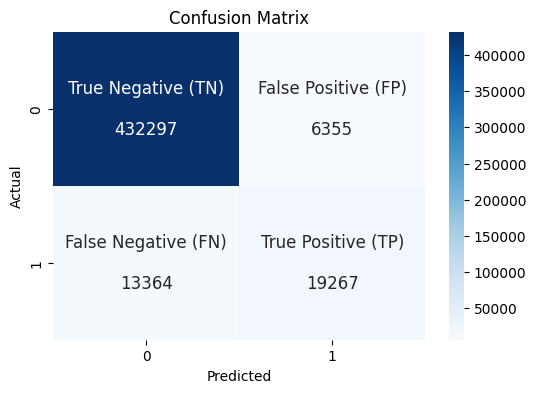

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#スタックモデル
# 1. 実際の目的変数と予測の目的変数の比較
correct_indices = np.where(y_train == oof_cat)[0]
incorrect_indices = np.where(y_train != oof_cat)[0]

print(f"Number of correct predictions: {len(correct_indices)}")
print(f"Number of incorrect predictions: {len(incorrect_indices)}")
print(f"Overall F1 Score: {score_cat:.4f}")

# 混同行列の計算
cm = confusion_matrix(y_train, oof_cat)

# ラベルの定義
labels = np.array([['True Negative (TN)', 'False Positive (FP)'],
                   ['False Negative (FN)', 'True Positive (TP)']])

# ラベルと値を組み合わせて表示用のテキストを作成
labels_val = np.char.add(np.char.add(labels, "\n\n"), cm.astype(str))

# 混同行列の表示
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=labels_val, fmt='', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# OOF予測結果を使って偽陽性と偽陰性のインデックスを取得
false_positives = np.where((y_train == 0) & (oof_cat == 1))[0]
false_negatives = np.where((y_train == 1) & (oof_cat == 0))[0]

# 偽陽性のデータを取得
df_false_positives = combined_train_data_transformed.iloc[false_positives]

# 偽陰性のデータを取得
df_false_negatives = combined_train_data_transformed.iloc[false_negatives]

print("False Positives Data: 不正取引と予測したけど通常の取引だった")
display(df_false_positives.head())

print("\nFalse Negatives Data: 通常の取引と予測したけど不正取引だった")
display(df_false_negatives.head())


False Positives Data: 不正取引と予測したけど通常の取引だった


,num__amount,num__credit_limit,num__per_capita_income_zipcode,num__yearly_income_person,num__total_debt,num__cards_issued,num__year_pin_last_changed,num__current_age,num__retirement_age,num__birth_year,...,cat__city_pca_2,cat__city_pca_3,cat__mcc_pca_0,cat__mcc_pca_1,cat__mcc_pca_2,cat__mcc_pca_3,cat__expires_pca_0,cat__expires_pca_1,cat__expires_pca_2,cat__expires_pca_3
136,22.700,15000.0,23029.0,46956.0,94340.0,2,2008,54,60,1966,...,-0.009189,0.007348,-0.020446,-0.025518,-0.029974,0.035441,-0.001269,-0.011753,-0.002209,0.000287
157,90.790,12600.0,21102.0,43021.0,86014.0,2,2014,59,67,1960,...,-0.011991,0.010152,-0.024777,-0.067163,-0.109922,0.100535,-0.026676,0.013281,-0.008214,0.010472
181,206.367,12600.0,21102.0,43021.0,86014.0,2,2014,59,67,1960,...,-0.011991,0.010152,-0.022211,-0.028479,-0.033999,0.040238,-0.026676,0.013281,-0.008214,0.010472
250,19.850,10300.0,20153.0,39082.0,16870.0,1,2013,68,65,1951,...,-0.281036,-0.650437,-0.031586,-0.052633,-0.072886,0.081427,0.062741,-0.298481,-0.428579,-0.701439
290,170.647,15000.0,23029.0,46956.0,94340.0,2,2008,54,60,1966,...,-0.009189,0.007348,-0.022413,-0.028757,-0.034377,0.040687,-0.001269,-0.011753,-0.002209,0.000287



False Negatives Data: 通常の取引と予測したけど不正取引だった


,num__amount,num__credit_limit,num__per_capita_income_zipcode,num__yearly_income_person,num__total_debt,num__cards_issued,num__year_pin_last_changed,num__current_age,num__retirement_age,num__birth_year,...,cat__city_pca_2,cat__city_pca_3,cat__mcc_pca_0,cat__mcc_pca_1,cat__mcc_pca_2,cat__mcc_pca_3,cat__expires_pca_0,cat__expires_pca_1,cat__expires_pca_2,cat__expires_pca_3
66,74.612,17211.0,15451.0,22158.0,19101.0,2,2013,75,67,1944,...,-0.015277,0.013017,-0.026561,-0.037379,-0.047069,0.055089,0.069706,-0.357076,0.815817,-0.033199
150,92.305,24090.0,27308.0,55682.0,82696.0,1,2009,56,68,1963,...,0.907275,-0.140756,0.874878,0.200507,0.119749,-0.122831,0.069706,-0.357076,0.815817,-0.033199
151,506.158,24090.0,27308.0,55682.0,82696.0,1,2009,56,68,1963,...,0.907275,-0.140756,-0.031586,-0.052633,-0.072886,0.081427,0.069706,-0.357076,0.815817,-0.033199
194,76.000,17211.0,15451.0,22158.0,19101.0,2,2013,75,67,1944,...,-0.015277,0.013017,-0.020489,-0.025573,-0.030044,0.035540,0.069706,-0.357076,0.815817,-0.033199
208,455.000,11592.0,16770.0,34190.0,39242.0,1,2015,59,68,1960,...,-0.226358,-0.221000,-0.020956,-0.026352,-0.031094,0.036784,0.824306,0.499606,0.020982,0.004566


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量の重要度を可視化する関数
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    plt.show()

# # OOFの予測と実際の値を比較する関数
# def visualize_oof_gt(oof, gt):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.scatter(oof, gt, alpha=0.5)
#     gt_max = gt.max()
#     ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
#     ax.set_xlabel("Out Of Fold")
#     ax.set_ylabel("Ground Truth")
#     ax.grid()
#     ax.legend()
#     fig.tight_layout()
#     plt.show()

# # テストの予測とOOFの予測を比較する関数
# def visualize_oof_pred(oof, pred):
#     fig, ax = plt.subplots(figsize=(8, 6))

#     bins = 100
#     ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
#     ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
#     ax.grid()
#     ax.legend()
#     fig.tight_layout()
#     plt.show()


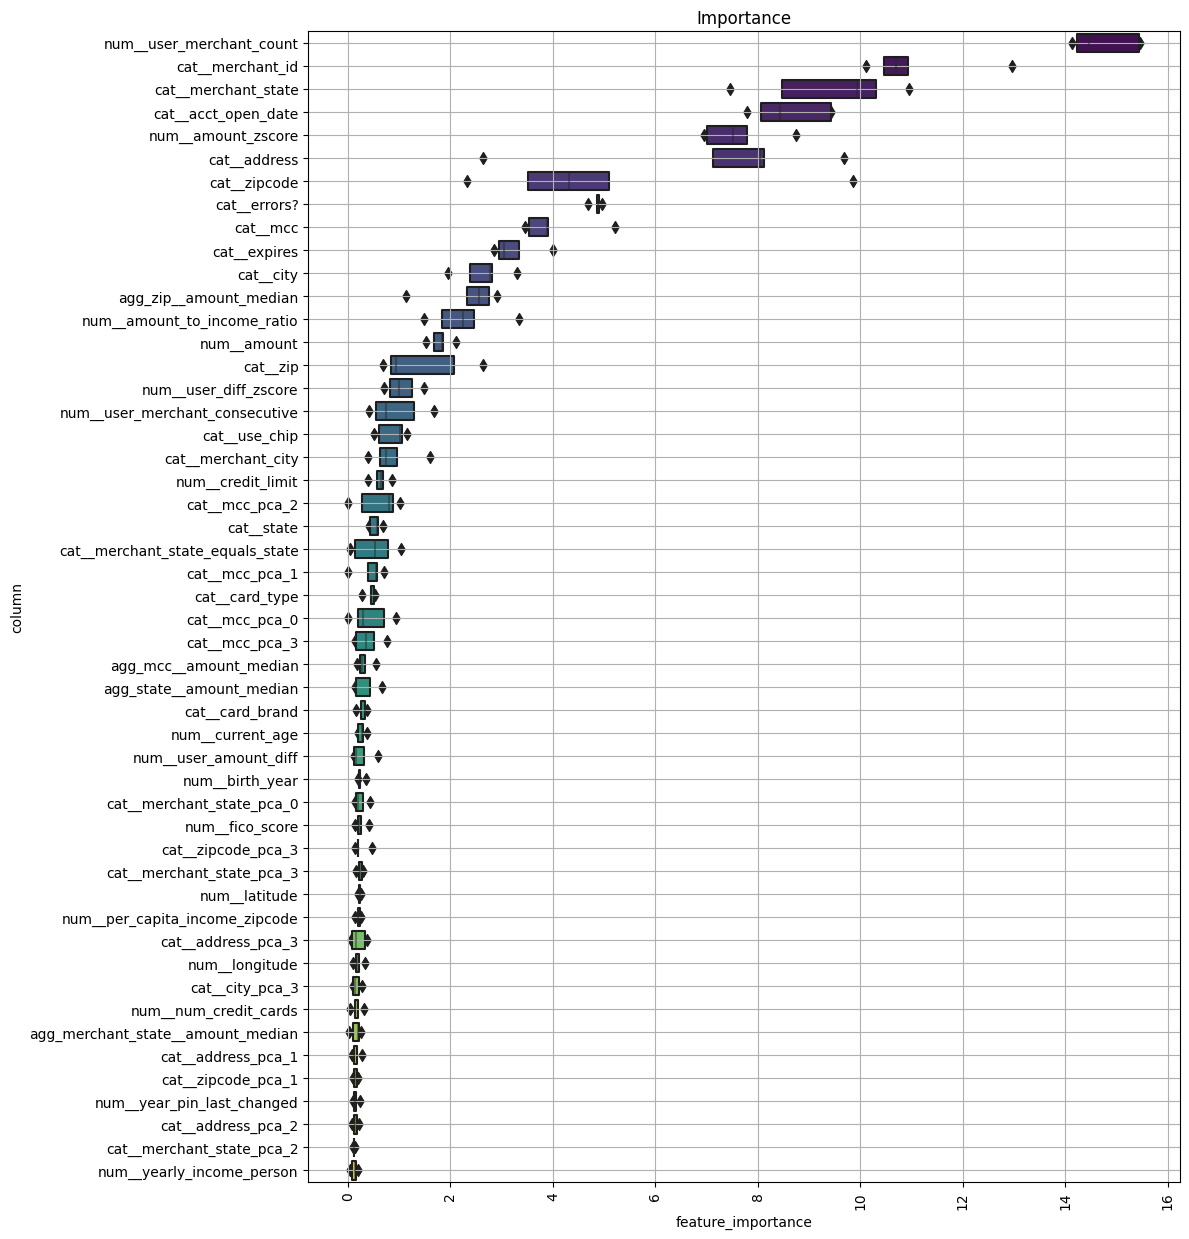

In [ ]:
# 特徴量の重要度を可視化
visualize_importance(models_cat, combined_train_data_transformed)

# # OOFの予測と実際の値を比較
# visualize_oof_gt(oof, y_train)

# # テストデータに対する予測を取得 (この部分はモデルとデータに応じて調整が必要)
# preds = np.mean([model.predict_proba(combined_test_data_transformed)[:, 1] for model in models], axis=0)

# # テストの予測とOOFの予測を比較
# visualize_oof_pred(oof, preds)

In [ ]:
import matplotlib.pyplot as plt

def plot_cv_vs_lb(cv_scores, lb_scores, model_names=None):
    """
    手持ちのデータのCVスコアとリーダーボードのスコアを比較する散布図を作成する関数。

    Parameters:
    - cv_scores: list, 手持ちのデータのCVスコアのリスト
    - lb_scores: list, リーダーボードのスコアのリスト
    - model_names: list, 各モデルの名前のリスト (オプション)

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(cv_scores, lb_scores, color='blue')

    if model_names:
        for i, txt in enumerate(model_names):
            plt.annotate(txt, (cv_scores[i], lb_scores[i]), fontsize=9, ha='right')

    max_score = max(max(cv_scores), max(lb_scores))
    min_score = min(min(cv_scores), min(lb_scores))

    plt.plot([min_score, max_score], [min_score, max_score], color='red', linestyle='--')

    plt.title("CV vs. Leaderboard Scores")
    plt.xlabel("CV Scores")
    plt.ylabel("Leaderboard Scores")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 使用例
cv_scores_sample = [0.6331]
lb_scores_sample = [0.6398840]
model_names_sample = ["sub 1 lgb"]

plot_cv_vs_lb(cv_scores_sample, lb_scores_sample, model_names_sample)


In [ ]:
# SHAP値を計算する関数
def compute_shap_values(model, X):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    return shap_values

# 各CVフォールドのSHAP値を格納するリスト
all_shap_values = []

# 訓練済みモデルからSHAP値を取得
for model in models:
    shap_values = compute_shap_values(model, combined_train_data_transformed)
    all_shap_values.append(shap_values)

# SHAP値の平均と分散を計算
mean_shap_values = np.mean(all_shap_values, axis=0)
std_shap_values = np.std(all_shap_values, axis=0)

# 平均SHAP値のSummary Plot
shap.summary_plot(mean_shap_values, combined_train_data_transformed)

In [ ]:
import shap

# Force Plot: 個別のデータポイントのSHAP値を可視化する。このプロットは、モデルの出力をベースラインの値から
# 予測の値までどのように変動させるかを示します。各特徴の影響度合いを色と長さで表現しています。
def plot_force_plot(model, X, index=0):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1][index], X.iloc[index])

# Dependence Plot: ある特徴の値に対するSHAP値の変動を可視化する。これにより、特徴の値が増加または減少すると
# 予測にどのような影響を与えるかを理解することができます。
def plot_dependence_plot(model, X, feature_name):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    shap.dependence_plot(feature_name, shap_values[1], X)

# Waterfall Plot: 個別のデータポイントにおける特徴の寄与度を順序付けて可視化する。
# これにより、予測の根拠となる主要な特徴を特定できます。
def plot_waterfall_plot(model, X, index=0):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    return shap.waterfall_plot(explainer.expected_value[1], shap_values[1][index], X.iloc[index])

# 実行コード:

# ここでは、訓練済みのモデルのリスト「models」から最初のモデルを使用します。
model = models_cat[0]

# # Force Plotの実行
# print("Visualizing Force Plot for the first data point:")
# plot_force_plot(model, combined_train_data_transformed, 0)

# Dependence Plotの実行 (ここでは特徴 'feature_name' に焦点を当てています。適切な特徴名に置き換えてください。)
feature_name = "cat_zip"
print(f"Visualizing Dependence Plot for feature: {feature_name}")
plot_dependence_plot(model, combined_train_data_transformed, feature_name)

# Waterfall Plotの実行
print("Visualizing Waterfall Plot for the first data point:")
plot_waterfall_plot(model, combined_train_data_transformed, 0)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

fold 1 - F1 Score: 0.6394
fold 2 - F1 Score: 0.6288
fold 3 - F1 Score: 0.6286
fold 4 - F1 Score: 0.6344
fold 5 - F1 Score: 0.6328
Sampling Rate 6.7 F1 Score: 0.6328
fold 1 - F1 Score: 0.6404
fold 2 - F1 Score: 0.6287
fold 3 - F1 Score: 0.6283
fold 4 - F1 Score: 0.6339
fold 5 - F1 Score: 0.6333
Sampling Rate 6.75 F1 Score: 0.6329
fold 1 - F1 Score: 0.6398
fold 2 - F1 Score: 0.6285
fold 3 - F1 Score: 0.6292
fold 4 - F1 Score: 0.6340
fold 5 - F1 Score: 0.6326
Sampling Rate 6.85 F1 Score: 0.6328
fold 1 - F1 Score: 0.6395
fold 2 - F1 Score: 0.6276
fold 3 - F1 Score: 0.6288
fold 4 - F1 Score: 0.6350
fold 5 - F1 Score: 0.6335
Sampling Rate 6.9 F1 Score: 0.6329


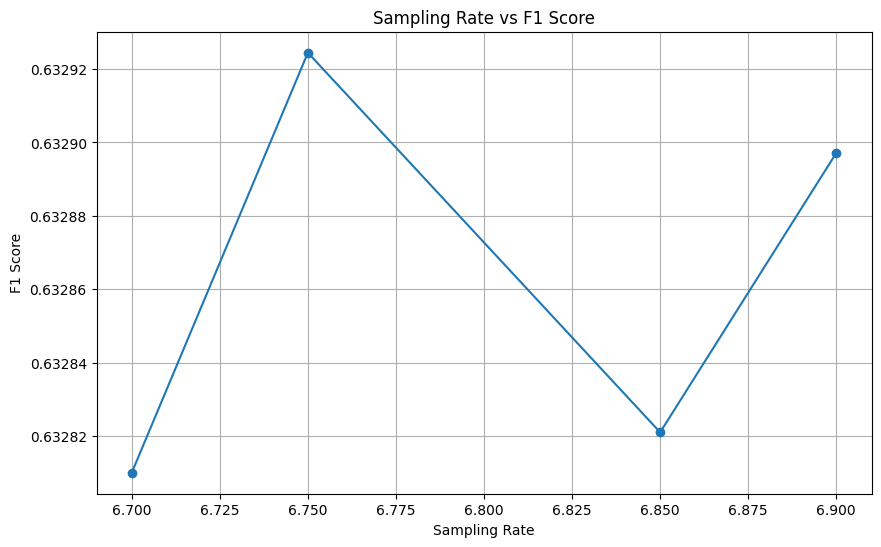

Best Sampling Rate: 6.75 with F1 Score: 0.6329
Best Sampling Rate: 6.75, (6.7 ~ 6.9) F1 Score: 0.6329


In [ ]:
# LightGBMのパラメータを設定
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 71,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'verbose': -1,
}

# 交差検証のインデックスを取得
cv = get_cv(combined_train_data_transformed)

def catboost_categorical_transform(X):
    # カテゴリ変数の各値を文字列に変換
    for col in categorical_cols:
        X[col] = X[col].astype(str)

    # カテゴリ変数を category dtype に変換
    for col in categorical_cols:
        X[col] = X[col].astype('category')

    # カテゴリ変数に "missing" カテゴリを追加
    for col in categorical_cols:
        if not "missing" in X[col].cat.categories:
            X[col] = X[col].cat.add_categories("missing")

    return X
# テストデータに対する予測を行う（catboostモデル単体）

combined_train_data_transformed = catboost_categorical_transform(combined_train_data_transformed)
combined_test_data_transformed = catboost_categorical_transform(combined_test_data_transformed)
categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()


# サンプリング倍率を調整して最適な倍率を探す
best_rate, best_score, sampling_rates, scores = find_best_sampling_rate(
    combined_train_data_transformed,
    y_train,
    cv,
    categorical_cols=categorical_cols,  # カテゴリ変数のリストをここに指定
    params=lgb_params,
    sampling_rates = [6.7, 6.75, 6.85, 6.9]

)

print(f"Best Sampling Rate: {best_rate}, ({min(sampling_rates)} ~ {max(sampling_rates)}) F1 Score: {best_score:.4f}")


Best Sampling Rate: 2.0, (0.5 ~ 2.0) F1 Score: 0.5468

Best Sampling Rate 3.0, (2.25 ~ 3.0) F1 Score: 0.5975

Best Sampling Rate 4.0,  (3.2 ~ 4.0) F1 Score: 0.6225

Best Sampling Rate: 4.5  (4.1 ~ 4.5) F1 Score: 0.6295

Best Sampling Rate: 6.0, (4.75 ~ 6.0) F1 Score: 0.6385

Best Sampling Rate: 7.0, (7.0 ~ 10.0) F1 Score: 0.6390

 Best Sampling Rate: 6.4, (6.2 ~ 7.4) F1 Score: 0.6392

Sampling Rate: 6.2, F1 Score: 0.6387

Sampling Rate: 6.4, F1 Score: 0.6392

Sampling Rate: 6.6, F1 Score: 0.6389

Sampling Rate: 6.8, F1 Score: 0.6390

Sampling Rate: 7.2, F1 Score: 0.6392

Sampling Rate: 7.4, F1 Score: 0.6385

データ前処理後

Sampling Rate: 6.2, F1 Score: 0.6319

Sampling Rate: 6.4, F1 Score: 0.6323

Sampling Rate: 6.6, F1 Score: 0.6329

Sampling Rate: 6.8, F1 Score: 0.6337

Sampling Rate: 7.2, F1 Score: 0.6335

##LGBM Best Sampling Rate: 6.8, (6.2 ~ 7.2) F1 Score: 0.6392   ##

PCA追加後のlgbm

Best Sampling Rate: 7, (5 ~ 8) F1 Score: 0.6332

Sampling Rate: 6.8 : 0.6335

PCA追加後のcat

Sampling Rate: 6.0, F1 Score: 0.6603

Sampling Rate: 6.5, F1 Score: 0.6619

Sampling Rate: 6.65, F1 Score: 0.6610

Sampling Rate: 6.8, F1 Score: 0.6618

Sampling Rate: 7.0, F1 Score: 0.6614

Sampling Rate: 7.5, F1 Score: 0.6608

##Cat Best Sampling Rate: 6.5 with F1 Score: 0.6619##



## CatBoostの主要なパラメータ

### 1. learning_rate (または eta)
- **説明**: 各ブースティングステップでのモデルの学習率。
- **デフォルト**: `0.03`

### 2. depth
- **説明**: 木の深さ。深い木はモデルをより複雑にしますが、過学習のリスクも増加します。
- **デフォルト**: `6`

### 3. l2_leaf_reg (または reg_lambda)
- **説明**: L2正則化の係数。大きい値はモデルをより保守的にします。
- **デフォルト**: `3`

### 4. iterations
- **説明**: ブースティングステップの総数。
- **デフォルト**: `1000`

### 5. random_strength
- **説明**: バギングの際の特徴選択のランダム性を制御します。
- **デフォルト**: `1`

### 6. bagging_temperature
- **説明**: バギングの強度を制御します。値が大きいと、より多くのバギングが行われます。
- **デフォルト**: `1`

### 7. od_type
- **説明**: 早期停止のタイプ。`Iter`は最後の改善から指定したイテレーション数だけ続けることを意味し、`IncToDec`は平均エラーが改善しない場合に停止します。
- **デフォルト**: `None`

### 8. od_wait
- **説明**: 早期停止を行うまでのイテレーション数。
- **デフォルト**: `20`

### 9. cat_features
- **説明**: カテゴリカル特徴のインデックスのリスト。CatBoostはこれを使用してカテゴリカル特徴を特別に処理します。

### 10. verbose
- **説明**: ログ出力の頻度。例えば、`verbose=50`は50イテレーションごとにログを出力します。

### 11. loss_function
- **説明**: 損失関数。二値分類の場合は`Logloss`、多クラス分類の場合は`MultiClass`、回帰の場合は`RMSE`など。

### 12. boosting_type
- **説明**: ブースティングのタイプ。デフォルトは`Ordered`で、通常のブースティングよりも遅いが、過学習を抑制する効果がある。`Plain`は通常のブースティング。



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6618
Fold 2 F1 Score: 0.6574
Fold 3 F1 Score: 0.6556
Fold 4 F1 Score: 0.6672
Fold 5 F1 Score: 0.6594
Overall F1 Score: 0.6603
Sampling Rate 6.0 F1 Score: 0.6603



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6646
Fold 2 F1 Score: 0.6591
Fold 3 F1 Score: 0.6557
Fold 4 F1 Score: 0.6690
Fold 5 F1 Score: 0.6609
Overall F1 Score: 0.6619
Sampling Rate 6.5 F1 Score: 0.6619



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6637
Fold 2 F1 Score: 0.6593
Fold 3 F1 Score: 0.6546
Fold 4 F1 Score: 0.6684
Fold 5 F1 Score: 0.6587
Overall F1 Score: 0.6610
Sampling Rate 6.65 F1 Score: 0.6610



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6644
Fold 2 F1 Score: 0.6572
Fold 3 F1 Score: 0.6558
Fold 4 F1 Score: 0.6687
Fold 5 F1 Score: 0.6626
Overall F1 Score: 0.6618
Sampling Rate 6.8 F1 Score: 0.6618



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6634
Fold 2 F1 Score: 0.6611
Fold 3 F1 Score: 0.6574
Fold 4 F1 Score: 0.6667
Fold 5 F1 Score: 0.6583
Overall F1 Score: 0.6614
Sampling Rate 7.0 F1 Score: 0.6614



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fold 1 F1 Score: 0.6635
Fold 2 F1 Score: 0.6591
Fold 3 F1 Score: 0.6542
Fold 4 F1 Score: 0.6677
Fold 5 F1 Score: 0.6596
Overall F1 Score: 0.6608
Sampling Rate 7.5 F1 Score: 0.6608


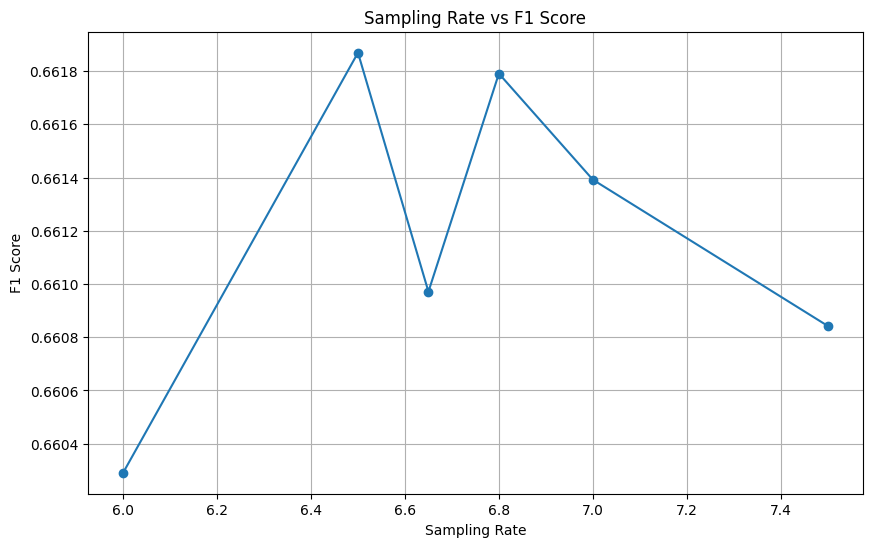

Best Sampling Rate: 6.5 with F1 Score: 0.6619


In [ ]:
# def find_best_sampling_rate_cat(X, y, cv, categorical_cols=None, params=None, sampling_rates=None):
#     """最適なサンプリング倍率を探す関数 (CatBoost用)"""

#     if sampling_rates is None:
#         sampling_rates = [1.0, 1.25, 1.5, 1.75, 2.0]

#     best_score = 0
#     best_rate = None
#     scores = []

#     for rate in sampling_rates:
#         score, _, _, _ = fit_catboost(X, y, cv, categorical_cols, params, sampling_rate=rate, random_state_us=71,verbose=False)
#         scores.append(score)

#         if score > best_score:
#             best_score = score
#             best_rate = rate

#         print(f"Sampling Rate {rate} F1 Score: {score:.4f}")

#     plt.figure(figsize=(10, 6))
#     plt.plot(sampling_rates, scores, marker="o", linestyle='-')
#     plt.xlabel("Sampling Rate")
#     plt.ylabel("F1 Score")
#     plt.title("Sampling Rate vs F1 Score")
#     plt.grid(True)
#     plt.show()

#     print(f"Best Sampling Rate: {best_rate} with F1 Score: {best_score:.4f}")
#     return best_rate, best_score, sampling_rates, scores

# # CatBoostのハイパーパラメータ
# cat_params = {
#     'iterations': 300,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'random_seed': 71,
# }

# categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# cv = get_cv(combined_train_data_transformed, n_fold=5, random_state=71)

# best_rate, best_score, sampling_rates, scores = find_best_sampling_rate_cat(
#     combined_train_data_transformed,
#     y_train,
#     cv,
#     categorical_cols=categorical_cols,
#     params=cat_params,
#     sampling_rates = [6.0, 6.5, 6.65, 6.8, 7.0, 7.5]
# )

In [ ]:
for i in range(len(sampling_rates)):
    print(f"Sampling Rate: {sampling_rates[i]}, F1 Score: {scores[i]:.4f}")


Sampling Rate: 6.0, F1 Score: 0.6603
Sampling Rate: 6.5, F1 Score: 0.6619
Sampling Rate: 6.65, F1 Score: 0.6610
Sampling Rate: 6.8, F1 Score: 0.6618
Sampling Rate: 7.0, F1 Score: 0.6614
Sampling Rate: 7.5, F1 Score: 0.6608


In [ ]:
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split

# # カテゴリ変数のリストを取得します。
# categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# # 交差検証のインデックスを取得します。
# cv = get_cv(combined_train_data_transformed, n_fold=5, random_state = 71)


# def objective(trial, data=combined_train_data_transformed, cv=cv, target=y_train, categorical_cols=categorical_cols):

#     if trial.number ==0:

#       params = {
#         'iterations': 300,
#         'depth': trial.suggest_int('depth', 6, 6),
#         'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.1),
#         'random_strength': trial.suggest_float('random_strength', 1, 1),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': 20,
#         'random_seed': 71,
#         'verbose': False
#       }

#     else:
#       params = {
#         'iterations': 300,
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'random_strength': trial.suggest_float('random_strength', 0, 100),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': 20,
#         'random_seed': 71,
#         'verbose': False
#         }

#     scores = []

#     all_scores = []
#     thresholds = []
#     for train_idx, valid_idx in cv:
#         X_train, X_val = data.iloc[train_idx], data.iloc[valid_idx]
#         y_train_fold, y_val = target.iloc[train_idx], target.iloc[valid_idx]

#         # アンダーサンプリングの適用
#         sampling_multiplier = 6.5
#         sampled_df = under_sampling(pd.concat([X_train, y_train_fold], axis=1), sampling_multiplier)
#         X_train_sampled = sampled_df.drop(columns=['is_fraud?'])
#         y_train_sampled = sampled_df['is_fraud?']

#         train_data = cb.Pool(data=X_train_sampled, label=y_train_sampled, cat_features=categorical_cols)
#         valid_data = cb.Pool(data=X_val, label=y_val, cat_features=categorical_cols)

#         model = cb.CatBoostClassifier(**params)
#         model.fit(train_data, eval_set=valid_data, early_stopping_rounds=50)

#         # 予測確率を取得
#         probas = model.predict(valid_data, prediction_type='Probability')[:, 1]

#         # 最適な閾値を探す
#         best_score = -1
#         best_threshold = 0.5
#         for threshold in np.linspace(0.01, 0.99, 100):
#             preds = (probas > threshold).astype(int)
#             score = f1_score(y_val, preds)
#             if score > best_score:
#                 best_score = score
#                 best_threshold = threshold

#         all_scores.append(best_score)
#         thresholds.append(best_threshold)

#     # CV全体での平均のf1スコアを返す
#     return np.mean(all_scores)

# # optunaのスタディを作成
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# # 最良のパラメータを表示
# print(study.best_params)

[I 2023-09-10 00:36:44,074] A new study created in memory with name: no-name-4978522a-0ae3-4cdf-8182-db6cde4a9c80
[W 2023-09-10 00:48:52,491] Trial 0 failed with parameters: {'depth': 6, 'learning_rate': 0.1, 'random_strength': 1.0, 'bagging_temperature': 0.745870882583084, 'od_type': 'IncToDec'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-36-b27b911f80d6>", line 59, in objective
    model.fit(train_data, eval_set=valid_data, early_stopping_rounds=50)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2319, in _fit
    self._train(
  File "/usr/

KeyboardInterrupt: ignored

In [ ]:
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split



# # カテゴリ変数のリストを取得します。
# categorical_cols = combined_train_data_transformed.select_dtypes(include=['object', 'category']).columns.tolist()

# # 交差検証のインデックスを取得します。
# cv = get_cv(combined_train_data_transformed, n_fold=5)

# def objective(trial, data=combined_train_data_transformed, cv=cv, target=y_train, categorical_cols=categorical_cols):
#     # ここでデータを訓練セットと検証セットに分割します
#     X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)

#     if trial.number ==0:
#         # パラメータのサンプリング
#         params = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'verbosity': -1,
#         'random_state': 71,
#         'boosting_type': 'gbdt',
# #         'num_leaves': 133,
# #         'max_depth':26,
#         'learning_rate':0.03,
#         'max_depth': trial.suggest_int('num_leaves', 26, 26),
#         'num_leaves': trial.suggest_int('max_depth', 133, 133),
#         'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.03),
#         'n_estimators': 1000,
#         'subsample': trial.suggest_float('subsample', 1.0, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree',1.0, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.0),
#         }
#     #4変数でサーチしたとき
#     #learning rate 0.01, 0.04
#     #max dep 12, 28
#     #num leaves 80, 190
#     #sampling 6, 8
#     #trial 22 with value: 0.6404212637913741.
#     #{'num_leaves': 133, 'max_depth': 26, 'learning_rate': 0.030000899938828797,
#     #'sampling_multiplier': 6.829395405173469}

# #     ７変数でサーチ
# #　　　　　　　　　　7変数でサーチした結果絞った範囲
# #     num_leaves : 40, 140
# #     max_depth : 15, 40
# #     learning_rate: 0.025, 0.06
# #     sampling_multiplier: 6.5, 8.5
# #     colsample_bytree: 0.05, 0.5
# #     reg_alpha: 1.0, 6.0
# #     reg_lambda: 1.0, 6.0

# #     best{'num_leaves': 83, 'max_depth': 24, 'learning_rate': 0.036452686045341576,
# #      'subsample': 0.648724489724644, 'colsample_bytree': 0.29823535315394095,
# #      'reg_alpha': 3.3239914864315008, 'reg_lambda': 3.810768963241007,
# #      'sampling_multiplier': 7.594845717415631}
# #     n_estimatorが変わるとガラッと変わる


#   # サンプリングレートをトライアルごとにサジェストします
#         sampling_multiplier = trial.suggest_float('sampling_multiplier', 6.8, 6.8)
#     else:
#         # パラメータのサンプリング
#         params = {
#             'objective': 'binary',
#             'metric': 'binary_logloss',
#             'verbosity': -1,
#             'random_state': 71,
#             'boosting_type': 'gbdt',
#             'num_leaves': trial.suggest_int('num_leaves', 80, 190),
#             'max_depth': trial.suggest_int('max_depth', 12, 28),
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.04),
#             'n_estimators': 1000,
#             'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#             'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#             'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         }
#                 # サンプリングレートをトライアルごとにサジェストします
#         sampling_multiplier = trial.suggest_float('sampling_multiplier',  6.0, 8.0)

#     # アンダーサンプリングの適用
#     sampled_df = under_sampling(pd.concat([X_train, y_train], axis=1), sampling_multiplier)
#     X_train_sampled = sampled_df.drop(columns=['is_fraud?'])
#     y_train_sampled = sampled_df['is_fraud?']

#     # モデルの初期化と訓練
#     train_data = lgb.Dataset(X_train_sampled, label=y_train_sampled, categorical_feature=categorical_cols)
#     val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, reference=train_data)
#     model = lgb.train(params, train_data, valid_sets=[val_data], early_stopping_rounds=50, verbose_eval=False)

#     # 予測とスコアの計算
#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred = (y_pred > 0.5).astype(int)
#     score = f1_score(y_val, y_pred)

#     return score


# # optunaのスタディを作成
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

# # 最良のパラメータを表示
# print(study.best_params)


In [ ]:
# 最適化の過程を表示
# vis.plot_optimization_history(study)

In [ ]:
# 各トライアルのパラメータの値を表示
# vis.plot_slice(study)


    #初期値{'num_leaves': 133, 'max_depth': 26, 'learning_rate': 0.030000899938828797,
    #'sampling_multiplier': 6.829395405173469}
            #探索'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#             'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#             'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),


In [ ]:
# パラメータ間の相関を表示
# vis.plot_contour(study, params=['num_leaves', 'max_depth'])
